In [1]:
from google.cloud import bigquery
import pandas as pd 
import chime   
import seaborn as sns
client = bigquery.Client("gcp-wow-rwds-ai-checkout-dev")

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

### <u>Matching Stores by Pre, During and Post Campaign Performance</u>

#### 1. Data Preparation

Retrieve sales and units by product and store. Jan 2022 until present to avoid COVID.

#### 2. Aggregate Data 

Aggregate sales at product and store level to weekly sums. </br></br>Also include covariates such as: 
    <ul><li>`discount_depth`, and </li>
    <li>`total_hours_unavailable` </li></ul>
    
to account for confounders later.

#### 3. Seasonal Decomposition and Adjustment

De-seasonalise the data to avoid confounding from seasonal effects.

#### 4. Define Campaign Periods

Retrieve 0/1 campaign_running variable to create pre, during and post campaign boundaries.
For the purposes of this analysis, only instore-only campaigns are considered to avoid potential biasing from online assets/

#### 5. Calculate Pre, During, and Post Campaign Sales

#### 6. Standardize Weekly Average Sales

Standardization normalizes the sales such that we can compare variances between stores on different scales. 

#### 7. Calculate Uplift in Seasonally Adjusted and Standardized Weekly Sales

#### 8. Derive Store Similarity Rankings

#### 9. Create Pairs for Twin Test-Control Study


In [62]:
check = client.query(
    """ 
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_two AS 
    SELECT 
        campaign_info.campaign_start_date,
        schema_one.campaign_id,
        schema_one.line_name,
        dim_campaigns.media_location,
        campaign_info.store_id,
        schema_one.week_number,
        campaign_info.is_compliant,
        schema_one.instore_only,
        schema_one.no_concurrent_campaign,
        schema_one.subcats, 
        schema_one.media_type
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_one schema_one
    LEFT JOIN `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` dim_campaigns 
        ON dim_campaigns.booking_number = schema_one.campaign_id 
        AND dim_campaigns.line_name = schema_one.line_name 
    LEFT JOIN (
        SELECT DISTINCT 
            campaign_id, 
            campaign_start_date, 
            quote_line, 
            store_id,
            CASE WHEN week_number = "Installation" THEN 1 ELSE CAST(SUBSTR(week_number, LENGTH(week_number)) AS INT64) END AS week_number, 
            result AS is_compliant
        FROM `gcp-wow-cart-data-prod-d710.cdm.fact_compass_activity` 
        WHERE 
            campaign_start_date >= DATE("2023-01-01") 
        AND 
            campaign_end_date < CURRENT_DATE()  
        AND 
            campaign_id LIKE "%WOW%"
        AND 
            missing_record_flag = 0
    ) campaign_info 
        ON schema_one.campaign_id = campaign_info.campaign_id 
        AND schema_one.line_name = campaign_info.quote_line
        AND schema_one.week_number = campaign_info.week_number 
    WHERE 
    schema_one.instore_only = 1 
    AND schema_one.no_concurrent_campaign = 1
    AND dim_campaigns.campaign_start_date >= DATE("2023-01-01")   
    AND dim_campaigns.campaign_end_date < CURRENT_DATE()
    ORDER BY campaign_id, line_name, week_number
    """
).result()
check_df = check.to_dataframe()
#check_df.to_csv("~/Downloads/Carto Incrementality Retro Test Control Schema Two.csv")
check_df

""


In [121]:
check = client.query(
    """ 
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_compliance_cohorts AS (
        WITH aggregated_data AS (
            SELECT 
                campaign_start_date, 
                campaign_id, 
                store_id, 
                week_number, 
                subcats, 
                ARRAY_TO_STRING(ARRAY_AGG(DISTINCT line_name ORDER BY line_name), ',') AS line_names_string, 
                ARRAY_TO_STRING(ARRAY_AGG(DISTINCT media_type ORDER BY media_type), ',') AS media_types_string  
            FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_two
            WHERE week_number = 1
            AND media_type <> "OTHERS"
            GROUP BY 1,2,3,4,5
        ),
        unique_combinations AS (
            SELECT DISTINCT
                campaign_id, 
                campaign_start_date, 
                media_types_string
            FROM aggregated_data
        ), 
        media_split_number_t AS (
            SELECT 
                *, 
                ROW_NUMBER() OVER(PARTITION BY campaign_id, campaign_start_date ORDER BY campaign_id, campaign_start_date) AS media_split_cohort
            FROM unique_combinations
        ) 
        SELECT 
            aggregated_data.*, 
            s2.line_name,
            s2.media_type,
            s2.is_compliant,
            media_split_number_t.media_split_cohort 
        FROM aggregated_data 
        LEFT JOIN media_split_number_t
            ON media_split_number_t.campaign_id = aggregated_data.campaign_id 
            AND media_split_number_t.campaign_start_date = aggregated_data.campaign_start_date
            AND media_split_number_t.media_types_string = aggregated_data.media_types_string
        LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_two s2
            ON s2.campaign_id = aggregated_data.campaign_id 
            AND s2.campaign_start_date = aggregated_data.campaign_start_date 
            AND s2.store_id = aggregated_data.store_id
        WHERE aggregated_data.week_number = 1
        AND s2.media_type <> "OTHERS" 
        AND s2.week_number = 1
        ORDER BY campaign_id, campaign_start_date, store_id
    ); 

SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_compliance_cohorts
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/media split cohort.csv")
check_df

,campaign_start_date,campaign_id,store_id,week_number,subcats,line_names_string,media_types_string,line_name,media_type,is_compliant,media_split_cohort
0,2023-04-12,WOW20000337,1002,1,DAIRY - DESSERTS,CI-10023294,DECAL,CI-10023294,DECAL,1,2
1,2023-04-12,WOW20000337,1003,1,DAIRY - DESSERTS,CI-10023294,DECAL,CI-10023294,DECAL,1,2
2,2023-04-12,WOW20000337,1004,1,DAIRY - DESSERTS,CI-10023294,DECAL,CI-10023294,DECAL,1,2
3,2023-04-12,WOW20000337,1008,1,DAIRY - DESSERTS,CI-10023293,BUS STOP,CI-10023293,BUS STOP,1,1
4,2023-04-12,WOW20000337,1030,1,DAIRY - DESSERTS,CI-10023293,BUS STOP,CI-10023293,BUS STOP,1,1
...,...,...,...,...,...,...,...,...,...,...,...
242775,2024-05-08,WOW20012038,7216,1,DIET & SPORT NUTRITION,CI-10142248,BUS STOP,CI-10142248,BUS STOP,1,1
242776,2024-05-08,WOW20012038,7217,1,DIET & SPORT NUTRITION,CI-10142248,BUS STOP,CI-10142248,BUS STOP,1,1
242777,2024-05-08,WOW20012038,7220,1,DIET & SPORT NUTRITION,CI-10142248,BUS STOP,CI-10142248,BUS STOP,1,1
242778,2024-05-08,WOW20012038,7223,1,DIET & SPORT NUTRITION,CI-10142248,BUS STOP,CI-10142248,BUS STOP,1,1


In [216]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023 AS (
    SELECT 
        cc.campaign_start_date,
        cc.campaign_id,
        cc.store_id,
        cc.week_number,
        cc.subcats,
        cc.media_types_string,
        cc.line_name,
        cc.media_type,
        cc.is_compliant,
        cc.media_split_cohort,
        ARRAY_AGG(campaign_sku) AS all_skus,
        COUNT(DISTINCT campaign_sku) AS total_skus,
        COUNT(DISTINCT stockout.article) AS stocktake_skus,
        SUM(stockout.total_trading_hours) AS total_trading_hours,
        SUM(stockout.n_trading_hours_oos) AS total_oos_trading_hours, 
        SUM(stockout.n_trading_hours_oos) / SUM(stockout.total_trading_hours) AS perc_of_trading_hours_oos
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_compliance_cohorts cc
    LEFT JOIN (
        SELECT DISTINCT 
            booking_number, 
            campaign_start_date, 
            line_name,
            quoteline_sku
        FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` ci 
    ) ci
        ON cc.campaign_id = ci.booking_number
        AND cc.campaign_start_date = ci.campaign_start_date
        AND cc.line_name = ci.line_name, 
    UNNEST(SPLIT(quoteline_sku, ',')) AS campaign_sku 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_percentage_of_trading_hours_oos  stockout
        ON stockout.article = campaign_sku 
        AND stockout.soh_date BETWEEN cc.campaign_start_date AND (cc.campaign_start_date + 6)
        AND stockout.site = cc.store_id 
    GROUP BY 1,2,3,4,5,6,7,8,9,10
)
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [233]:
check = client.query(
    """ 
    SELECT DISTINCT 
        trading.campaign_start_date, 
        trading.store_id, 
        sku, 
        soh_t.article
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023_by_trading_hour trading,
    UNNEST(campaign_skus) AS sku
    LEFT JOIN gcp-wow-wiq-fa-prod.inventory_asset.stock_on_hand soh_t 
        ON soh_t.article = sku 
        AND soh_t.soh_date = trading.campaign_start_date 
        AND soh_t.site = trading.store_id
    WHERE total_oos_trading_hours IS NULL
    

    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_start_date,store_id,sku,article
0,2023-08-02,2509,172188,172188
1,2023-04-12,7008,265577,265577
2,2024-03-06,2572,250693,None
3,2023-11-22,2055,390421,390421
4,2024-02-07,2588,394736,394736
...,...,...,...,...
164749,2023-08-30,1106,958760,None
164750,2023-08-30,1008,958760,None
164751,2023-08-30,1561,958760,None
164752,2023-08-30,3174,958760,None


In [238]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_test AS (
    SELECT DISTINCT 
        trading.campaign_start_date, 
        trading.store_id, 
        sku, 
        soh_t.article
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023_by_trading_hour trading,
    UNNEST(campaign_skus) AS sku
    LEFT JOIN (SELECT DISTINCT article, soh_date, site FROM gcp-wow-wiq-fa-prod.inventory_asset.stock_on_hand WHERE sales_organisation = "1005" AND soh_date >= DATE("2023-01-01")) soh_t 
        ON soh_t.article = sku 
        AND soh_t.soh_date BETWEEN trading.campaign_start_date AND DATE_ADD(trading.campaign_start_date, INTERVAL 6 DAY)
        AND soh_t.site = trading.store_id
    WHERE total_oos_trading_hours IS NULL
);
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [ ]:
check = client.query(
    """ 
    SELECT 
        t.*, 
        dim_site.SiteDescription, 
        am.ArticleDescription
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_test t
    LEFT JOIN `gcp-wow-ent-im-tbl-prod.adp_dm_masterdata_view.dim_site_v` dim_site 
        ON t.store_id = dim_site.Site 
    LEFT JOIN (SELECT DISTINCT Article, ArticleDescription FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` WHERE SalesOrg = 1005) am 
        ON t.article = am.Article  
    WHERE t.article IS NULL
    AND dim_site.SalesOrganisation = "1005"
    ORDER BY store_id, sku, campaign_start_date
    LIMIT 500
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [298]:
check = client.query(
    """ 
--CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliance_and_instock_trading_hours AS (
    with step_one AS (
        SELECT 
            campaign_id,
            store_id,
            --COUNT(DISTINCT campaign_id) AS all_campaigns,
            --COUNT(DISTINCT CASE WHEN total_trading_hours IS NULL THEN campaign_id ELSE NULL END) AS campaigns_with_missing_sku_counts
            COUNT(DISTINCT sku) AS total_store_skus,
            COUNT(DISTINCT CASE WHEN total_trading_hours IS NULL THEN sku ELSE NULL END) AS unchecked_stock_level_skus,
            COUNT(DISTINCT CASE WHEN total_trading_hours IS NULL THEN sku ELSE NULL END) / COUNT(DISTINCT sku) unchecked_stock_level_skus_perc
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023_by_trading_hour, 
        UNNEST(campaign_skus) sku
        GROUP BY 1,2
    ) --, step_two AS (
        SELECT trading.*
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023_by_trading_hour trading
        LEFT JOIN step_one 
            ON step_one.campaign_id = trading.campaign_id 
            AND step_one.store_id = trading.store_id 
        WHERE step_one.unchecked_stock_level_skus_perc <= 0.025
    /*) 
    SELECT 
        campaign_id,
        CONCAT("GROUP ", media_split_cohort) AS test_group, 
        media_types_string,
        subcats,
        media_type,
        COUNT(DISTINCT CASE WHEN is_compliant = 1 THEN store_id ELSE NULL END) AS compliant_stores,
        COUNT(DISTINCT CASE WHEN is_compliant = 0 THEN store_id ELSE NULL END) AS non_compliant_stores, 
        COUNT(DISTINCT CASE WHEN perc_of_trading_hours_oos <= .05 AND is_compliant = 1 THEN store_id ELSE NULL END) AS compliant_stores_at_stock_threshold_95pc,
        COUNT(DISTINCT CASE WHEN perc_of_trading_hours_oos <= .05 AND is_compliant = 0 THEN store_id ELSE NULL END) AS non_compliant_stores_at_stock_threshold_95pc,
        COUNT(DISTINCT CASE WHEN perc_of_trading_hours_oos <= .02 AND is_compliant = 1 THEN store_id ELSE NULL END) AS compliant_stores_at_stock_threshold_98pc,
        COUNT(DISTINCT CASE WHEN perc_of_trading_hours_oos <= .02 AND is_compliant = 0 THEN store_id ELSE NULL END) AS non_compliant_stores_at_stock_threshold_98pc
    FROM step_two
    GROUP BY 1,2,3,4,5,media_split_cohort
    ORDER BY campaign_id, media_split_cohort
 */
--);
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_start_date,campaign_id,store_id,week_number,subcats,media_types_string,line_name,media_type,is_compliant,media_split_cohort,campaign_skus,total_skus,stocktake_skus,total_trading_hours,total_oos_trading_hours,perc_of_trading_hours_oos
0,2023-03-08,WOW20000346,5652,1,MEDICINAL,BUS STOP,CI-10000275,BUS STOP,1,1,"[208056, 136634]",2,2,204,0,0.00
1,2023-03-08,WOW20000346,2590,1,MEDICINAL,BUS STOP,CI-10000275,BUS STOP,1,1,"[136634, 208056]",2,2,154,0,0.00
2,2023-03-08,WOW20000346,1317,1,MEDICINAL,BUS STOP,CI-10000275,BUS STOP,1,1,"[136634, 208056]",2,2,192,0,0.00
3,2023-03-08,WOW20000346,2614,1,MEDICINAL,BUS STOP,CI-10000275,BUS STOP,1,1,"[136634, 208056]",2,2,170,0,0.00
4,2023-03-08,WOW20000346,3169,1,MEDICINAL,BUS STOP,CI-10000275,BUS STOP,1,1,"[136634, 208056]",2,2,192,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199686,2024-05-08,WOW20012038,2442,1,DIET & SPORT NUTRITION,BUS STOP,CI-10142248,BUS STOP,1,1,"[390921, 392182, 391845, 391926, 392142]",5,5,500,0,0.00
199687,2024-05-08,WOW20012038,2507,1,DIET & SPORT NUTRITION,BUS STOP,CI-10142248,BUS STOP,1,1,"[391926, 392142, 392182, 390921, 391845]",5,5,500,0,0.00
199688,2024-05-08,WOW20012038,2075,1,DIET & SPORT NUTRITION,BUS STOP,CI-10142248,BUS STOP,1,1,"[392142, 391845, 392182, 391926, 390921]",5,5,500,0,0.00
199689,2024-05-08,WOW20012038,2534,1,DIET & SPORT NUTRITION,BUS STOP,CI-10142248,BUS STOP,1,1,"[391845, 391926, 392142, 390921, 392182]",5,5,500,105,0.21


In [312]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliance_and_instock_trading_hours_sales_results AS (
    with step_one AS (
        SELECT 
            campaign_id,
            store_id,
            --COUNT(DISTINCT campaign_id) AS all_campaigns,
            --COUNT(DISTINCT CASE WHEN total_trading_hours IS NULL THEN campaign_id ELSE NULL END) AS campaigns_with_missing_sku_counts
            COUNT(DISTINCT sku) AS total_store_skus,
            COUNT(DISTINCT CASE WHEN total_trading_hours IS NULL THEN sku ELSE NULL END) AS unchecked_stock_level_skus,
            COUNT(DISTINCT CASE WHEN total_trading_hours IS NULL THEN sku ELSE NULL END) / COUNT(DISTINCT sku) unchecked_stock_level_skus_perc
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023_by_trading_hour, 
        UNNEST(campaign_skus) sku
        GROUP BY 1,2
    ), 



    step_two AS (
        SELECT 
            trading.campaign_start_date,
            trading.campaign_id, 
            CONCAT("GROUP ", trading.media_split_cohort) AS test_group,
            trading.store_id,
            ARRAY_AGG(CASE WHEN is_compliant = 1 THEN media_type ELSE NULL END IGNORE NULLS) AS compliant_media_types,
            ARRAY_AGG(CASE WHEN is_compliant = 0 THEN media_type ELSE NULL END IGNORE NULLS) AS non_compliant_media_types
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023_by_trading_hour trading
        GROUP BY 1,2,3,4 
    ),

    -- unnest and roll up the distinct skus from all "week 1" media types
    -- this allows us to compare performance across all campaign skus regardless of which asset ran or was compliant
    -- this gives us an objective measure of whether an asset had an influence or whether sales were the same or higher without the asset
    step_three AS (
        SELECT 
            trading.campaign_start_date,
            trading.campaign_id,
            -- unnest and roll up the distinct skus from all "week 1" media types
            ARRAY_AGG(DISTINCT campaign_sku IGNORE NULLS) AS all_campaign_skus 
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023_by_trading_hour trading
        LEFT JOIN `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` ci 
            ON trading.campaign_start_date = ci.media_start_date -- joining only the media and skus that ran on the campaign_start_date to get week 1 media only
            AND trading.campaign_id = ci.booking_number, 
        UNNEST(SPLIT(quoteline_sku, ",")) campaign_sku
        GROUP BY 1,2
    )
        SELECT 
            trading.campaign_start_date,
            trading.campaign_id,
            CONCAT("GROUP ", trading.media_split_cohort) AS test_group,
            trading.store_id,
            trading.week_number,
            trading.subcats,
            trading.media_types_string,
            trading.line_name,
            ARRAY_TO_STRING(step_two.compliant_media_types, ", ") AS compliant_media_types,
            ARRAY_TO_STRING(step_two.non_compliant_media_types, ", ") AS non_compliant_media_types,
            ARRAY_AGG(campaign_sku) AS campaign_skus,
            
            -- Pre Period Sales (total and daily avg)
            COUNT(DISTINCT DATE(ass_pre_period.start_txn_time)) AS n_days_pre_period,
            SUM(ass_pre_period.tot_amt_incld_gst) AS total_sales_pre_period,
            COUNT(DISTINCT ass_pre_period.basket_key) AS total_baskets_pre_period,
            --SUM(ass_pre_period.tot_amt_incld_gst) / COUNT(DISTINCT DATE(ass_pre_period.start_txn_time)) AS daily_avg_sales_pre_period,

            -- Campaign Period Sales (total and daily avg)
            COUNT(DISTINCT DATE(ass_campaign_period.start_txn_time)) AS n_days_campaign_period,
            SUM(ass_campaign_period.tot_amt_incld_gst) AS total_sales_campaign_period,
            COUNT(DISTINCT ass_campaign_period.basket_key) AS total_baskets_campaign_period,
            --SUM(ass_campaign_period.tot_amt_incld_gst) / COUNT(DISTINCT DATE(ass_campaign_period.start_txn_time)) AS daily_avg_sales_campaign_period,

            -- Post Period Sales (total and daily avg)
            COUNT(DISTINCT DATE(ass_post_period.start_txn_time)) AS n_days_post_period,
            SUM(ass_post_period.tot_amt_incld_gst) AS total_sales_post_period,
            COUNT(DISTINCT ass_post_period.basket_key) AS total_baskets_post_period
            --SUM(ass_post_period.tot_amt_incld_gst) / COUNT(DISTINCT DATE(ass_post_period.start_txn_time)) AS daily_avg_sales_post_period



        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023_by_trading_hour trading
        LEFT JOIN step_one 
            ON step_one.campaign_id = trading.campaign_id 
            AND step_one.store_id = trading.store_id
        LEFT JOIN step_two 
            ON step_two.campaign_id = trading.campaign_id 
            AND step_two.campaign_start_date = trading.campaign_start_date  
            AND step_two.store_id = trading.store_id
        LEFT JOIN step_three 
            ON step_three.campaign_id = trading.campaign_id 
            AND step_three.campaign_start_date = trading.campaign_start_date, 
        UNNEST(all_campaign_skus) AS campaign_sku
        
        -- Pre Period
        LEFT JOIN `gcp-wow-food-wlx-digaspt-dev.wdp_tables.article_sales_summary`  ass_pre_period
            ON ass_pre_period.store_nbr = CAST(trading.store_id AS INT64)
            AND DATE(ass_pre_period.start_txn_time) BETWEEN DATE_ADD(trading.campaign_start_date, INTERVAL -6 MONTH) AND DATE_ADD(trading.campaign_start_date, INTERVAL -1 DAY)
            AND ass_pre_period.Article = campaign_sku
        
        -- Campaign Period
        LEFT JOIN `gcp-wow-food-wlx-digaspt-dev.wdp_tables.article_sales_summary`  ass_campaign_period
            ON ass_campaign_period.store_nbr = CAST(trading.store_id AS INT64)
            AND DATE(ass_campaign_period.start_txn_time) BETWEEN trading.campaign_start_date AND DATE_ADD(trading.campaign_start_date, INTERVAL 7 DAY)
            AND ass_campaign_period.Article = campaign_sku

        -- Post Period
        LEFT JOIN `gcp-wow-food-wlx-digaspt-dev.wdp_tables.article_sales_summary`  ass_post_period
            ON ass_post_period.store_nbr = CAST(trading.store_id AS INT64)
            AND DATE(ass_post_period.start_txn_time) BETWEEN DATE_ADD(trading.campaign_start_date, INTERVAL 7 DAY) AND DATE_ADD(trading.campaign_start_date, INTERVAL 28 DAY)
            AND ass_post_period.Article = campaign_sku
            
        WHERE step_one.unchecked_stock_level_skus_perc <= 0.025
        GROUP BY 1,2,3,4,5,6,7,8,9,10
);
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

KeyboardInterrupt: 

In [9]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE `gcp-wow-food-wlx-digaspt-dev.playground.order_and_subcat_monthly_averages` AS (
with total_orders AS (
    SELECT 
        DATE_TRUNC(start_txn_date, MONTH) AS order_month, 
        crn,
        COUNT(DISTINCT basket_key) AS n_orders 
    FROM `gcp-wow-cart-data-prod-d710.wdp_tables.vw_bi_article_sales` 
    WHERE 
        division_nbr = 1005 
    AND 
        start_txn_date >= DATE("2024-01-01")
    GROUP BY 1,2
), 
subcat_orders AS (
    SELECT 
        DATE_TRUNC(start_txn_date, MONTH) AS order_month, 
        crn, 
        subcat, 
        COUNT(DISTINCT basket_key) AS n_orders_subcat 
    FROM `gcp-wow-cart-data-prod-d710.wdp_tables.vw_bi_article_sales` 
    WHERE 
        division_nbr = 1005 
    AND 
        start_txn_date >= DATE("2024-01-01")
    GROUP BY 1,2,3
),
rolling_average_total_orders AS (
    SELECT 
        crn,
        order_month, 
        n_orders,
        AVG(n_orders) OVER (
            PARTITION BY crn
            ORDER BY crn, order_month 
            RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS rolling_average_monthly_orders 
    FROM total_orders
),
rolling_average_subcat_orders AS (
    SELECT 
        crn, 
        order_month, 
        subcat,
        n_orders_subcat,
        AVG(n_orders_subcat) OVER (
            PARTITION BY crn, subcat
            ORDER BY crn, subcat, order_month 
            RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS rolling_average_monthly_subcat_orders 
    FROM subcat_orders
)
SELECT 
    rolling_average_total_orders.crn, 
    rolling_average_total_orders.order_month, 
    rolling_average_total_orders.n_orders,
    rolling_average_monthly_orders,
    rolling_average_subcat_orders.subcat, 
    rolling_average_subcat_orders.n_orders_subcat,
    rolling_average_monthly_subcat_orders
FROM rolling_average_total_orders 
LEFT JOIN rolling_average_subcat_orders 
    ON rolling_average_total_orders.crn = rolling_average_subcat_orders.crn
    AND rolling_average_total_orders.order_month = rolling_average_subcat_orders.order_month
);
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [15]:
check = client.query(
    """ 
    SELECT MIN(start_txn_date) as min_date, MAX(start_txn_date) AS max_date FROM `gcp-wow-cart-data-prod-d710.wdp_tables.vw_bi_article_sales` LIMIT 20
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,min_date,max_date
0,2022-04-14,2022-04-14


In [269]:
check = client.query(
    """ 
    SELECT 
        *
    FROM gcp-wow-wiq-fa-prod.inventory_asset.stock_on_hand 
    WHERE soh_date BETWEEN DATE("2023-08-30") AND DATE_ADD(DATE("2023-08-30"), INTERVAL 6 DAY)
    AND sales_organisation = "1005"
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

KeyboardInterrupt: 

In [ ]:
    WHERE t.article IS NULL
    AND dim_site.SalesOrganisation = "1005"
    ORDER BY store_id, sku, campaign_start_date
    LIMIT 500
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [327]:

check = client.query(
    """ 
with step_one AS (
    SELECT 
        brands, 
        COUNT(DISTINCT CASE WHEN exposed_shoppers_7_days > 0 AND converted_shoppers_7_days = 0 THEN booking_id ELSE NULL END) AS n_bookings_no_sales,
        COUNT(DISTINCT CASE WHEN exposed_shoppers_7_days > 0 AND converted_shoppers_7_days > 0 THEN booking_id ELSE NULL END) AS n_bookings_with_sales
    --FROM `gcp-wow-food-wlx-digaspt-dev.playground.campaign_exposed_conversions_brand_level` 
    --FROM `gcp-wow-food-wlx-digaspt-dev.playground.campaign_exposed_sales_7_days_sku_level`
    FROM `gcp-wow-food-wlx-digaspt-dev.playground.campaign_exposed_sales_7_days_aggregated_brand_level`
    --WHERE tot_net_incld_gst IS NOT NULL 
    GROUP BY 1
    --ORDER BY 1,2
) 
SELECT 
    COUNT(DISTINCT CASE WHEN n_bookings_no_sales = 0 AND n_bookings_with_sales > 0 THEN brands ELSE NULL END) AS n_brands_with_no_issues,
    COUNT(DISTINCT CASE WHEN n_bookings_no_sales > 0 AND n_bookings_with_sales = 0 THEN brands ELSE NULL END) AS n_brands_with_issues
FROM step_one
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,n_brands_with_no_issues,n_brands_with_issues
0,38,397


In [ ]:

check = client.query(
    """ 
with step_one AS (
    SELECT 
        brands, 
        COUNT(DISTINCT CASE WHEN exposed_shoppers_7_days > 0 AND converted_shoppers_7_days = 0 THEN booking_id ELSE NULL END) AS n_bookings_no_sales,
        COUNT(DISTINCT CASE WHEN exposed_shoppers_7_days > 0 AND converted_shoppers_7_days > 0 THEN booking_id ELSE NULL END) AS n_bookings_with_sales
    --FROM `gcp-wow-food-wlx-digaspt-dev.playground.campaign_exposed_conversions_brand_level` 
    --FROM `gcp-wow-food-wlx-digaspt-dev.playground.campaign_exposed_sales_7_days_sku_level`
    FROM `gcp-wow-food-wlx-digaspt-dev.playground.campaign_exposed_sales_7_days_aggregated_brand_level`
    --WHERE tot_net_incld_gst IS NOT NULL 
    GROUP BY 1
    --ORDER BY 1,2
) 
SELECT 
    COUNT(DISTINCT CASE WHEN n_bookings_no_sales = 0 AND n_bookings_with_sales > 0 THEN brands ELSE NULL END) AS n_brands_with_no_issues,
    COUNT(DISTINCT CASE WHEN n_bookings_no_sales > 0 AND n_bookings_with_sales = 0 THEN brands ELSE NULL END) AS n_brands_with_issues
FROM step_one
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [ ]:
check = client.query(
    """ 
    SELECT 
        cc.*, 
        ARRAY_AGG(DISTINCT campaign_sku IGNORE NULLS ORDER BY campaign_sku) AS articles_oos
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_compliance_cohorts cc
    LEFT JOIN (
        SELECT DISTINCT 
            booking_number, 
            campaign_start_date, 
            case when compliance_media_type like '%AISLE FIN%' then 'AISLE FIN' 
            when compliance_media_type like '%BUS STOP%' then 'BUS STOP'
            when compliance_media_type like '%CATEGORY HEADER%' then 'CATEGORY HEADER'
            when compliance_media_type like '%DECAL%' then 'DECAL'
            when compliance_media_type like '%FLOOR MEDIA%' then 'FLOOR MEDIA' 
            else 'OTHERS' end as media_type, 
            quoteline_sku 
        FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` ci 
    ) ci
        ON cc.campaign_id = ci.booking_number
        AND cc.campaign_start_date = ci.campaign_start_date
        AND cc.media_type = ci.media_type, 
    UNNEST(SPLIT(quoteline_sku, ',')) AS campaign_sku 
    GROUP BY 1,2,3,4,5,6,7,8,9,10,11
    LIMIT 20
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [ ]:
check = client.query(
    """ 
    SELECT 
        COUNT(DISTINCT CASE WHEN total_trading_hours IS NULL THEN CONCAT(campaign_id, store_id) ELSE NULL END) AS null_trading_campaign_stores,
        COUNT(DISTINCT CASE WHEN total_trading_hours IS NOT NULL THEN CONCAT(campaign_id, store_id) ELSE NULL END) AS not_null_trading_campaign_stores  
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023 a
    --WHERE total_oos_trading_hours IS NOT NULL
    --ORDER BY campaign_id, media_types_string, media_type, store_id
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df.to_csv("~/Downloads/media split cohort.csv")
check_df

,null_trading_campaign_stores,not_null_trading_campaign_stores
0,157254,42230


In [217]:
check = client.query(
    """ 
    WITH 
        skus AS (
            SELECT DISTINCT 
                campaign_sku
            FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023, 
            UNNEST(all_skus) AS campaign_sku
            WHERE campaign_sku IS NOT NULL
        ),

        hours AS (
            SELECT hour
            FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
        )
        
            SELECT 
                COUNT(DISTINCT soh_t.article) AS soht_articles,
                COUNT(DISTINCT skus.campaign_sku) AS n_skus
            FROM skus
            LEFT JOIN gcp-wow-wiq-fa-prod.inventory_asset.stock_on_hand soh_t 
                ON soh_t.article = skus.campaign_sku
            WHERE soh_date >= DATE("2023-01-01")
            AND sales_organisation = "1005"
        
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,soht_articles,n_skus
0,1502,1502


In [168]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_hourly_stock_on_hand AS (
    WITH 
        skus AS (
            SELECT DISTINCT 
                campaign_sku
            FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023, 
            UNNEST(all_skus) AS campaign_sku
            WHERE campaign_sku IS NOT NULL
        ),

        hours AS (
            SELECT hour
            FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
        ),
        date_store_article_combinations AS (
            SELECT DISTINCT soh_date, site, article
            FROM gcp-wow-wiq-fa-prod.inventory_asset.stock_on_hand soh_t 
            INNER JOIN skus
                ON soh_t.article = skus.campaign_sku
            WHERE soh_date >= DATE("2023-01-01")
            AND sales_organisation = "1005"
        ),
        expanded_data AS (
            SELECT 
                dsa.soh_date,
                h.hour,
                dsa.site,
                dsa.article
            FROM 
                date_store_article_combinations dsa
            CROSS JOIN
                hours h
        ),
        joined_data AS (
            SELECT 
                ed.soh_date,
                ed.hour,
                ed.site,
                ed.article,
                od.soh
            FROM 
                expanded_data ed
            LEFT JOIN gcp-wow-wiq-fa-prod.inventory_asset.stock_on_hand od
            ON 
                ed.soh_date = od.soh_date AND 
                ed.hour = od.soh_hour AND 
                ed.site = od.site AND 
                ed.article = od.article
        )
    SELECT
        soh_date,
        hour,
        site,
        article,
        LAST_VALUE(soh IGNORE NULLS) OVER (
            PARTITION BY site, article
            ORDER BY soh_date, hour
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS stock_level
    FROM
        joined_data
    ORDER BY
        soh_date, site, article, hour
);

    
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [199]:
check = client.query(
    """ 
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_percentage_of_trading_hours_oos AS (
    with 

    corrected_store_trading_times AS (
        SELECT 
            Site,
            IF(MondaySiteClosingTime = '240000', '000000', MondaySiteClosingTime) AS ValidMondaySiteClosingTime,
            IF(TuesdaySiteClosingTime = '240000', '000000', TuesdaySiteClosingTime) AS ValidTuesdaySiteClosingTime,
            IF(WednesdaySiteClosingTime = '240000', '000000', WednesdaySiteClosingTime) AS ValidWednesdaySiteClosingTime,
            IF(ThursdaySiteClosingTime = '240000', '000000', ThursdaySiteClosingTime) AS ValidThursdaySiteClosingTime,
            IF(FridaySiteClosingTime = '240000', '000000', FridaySiteClosingTime) AS ValidFridaySiteClosingTime,
            IF(SaturdaySiteClosingTime = '240000', '000000', SaturdaySiteClosingTime) AS ValidSaturdaySiteClosingTime,
            IF(SundaySiteClosingTime = '240000', '000000', SundaySiteClosingTime) AS ValidSundaySiteClosingTime,
            MondaySiteOpeningTime,
            TuesdaySiteOpeningTime,
            WednesdaySiteOpeningTime,
            ThursdaySiteOpeningTime,
            FridaySiteOpeningTime,
            SaturdaySiteOpeningTime,
            SundaySiteOpeningTime
        FROM
            gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_site_v 
        WHERE 
            SalesOrg = 1005
    ),

    store_trading_hours AS (
        SELECT
            Site,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', MondaySiteOpeningTime))) AS MondayOpeningHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', ValidMondaySiteClosingTime))) + IF(EXTRACT(MINUTE FROM TIME(PARSE_TIME('%H%M%S', ValidMondaySiteClosingTime))) > 0, 1, 0) AS MondayClosingHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', TuesdaySiteOpeningTime))) AS TuesdayOpeningHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', ValidTuesdaySiteClosingTime))) + IF(EXTRACT(MINUTE FROM TIME(PARSE_TIME('%H%M%S', ValidTuesdaySiteClosingTime))) > 0, 1, 0) AS TuesdayClosingHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', WednesdaySiteOpeningTime))) AS WednesdayOpeningHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', ValidWednesdaySiteClosingTime))) + IF(EXTRACT(MINUTE FROM TIME(PARSE_TIME('%H%M%S', ValidWednesdaySiteClosingTime))) > 0, 1, 0) AS WednesdayClosingHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', ThursdaySiteOpeningTime))) AS ThursdayOpeningHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', ValidThursdaySiteClosingTime))) + IF(EXTRACT(MINUTE FROM TIME(PARSE_TIME('%H%M%S', ValidThursdaySiteClosingTime))) > 0, 1, 0) AS ThursdayClosingHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', FridaySiteOpeningTime))) AS FridayOpeningHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', ValidFridaySiteClosingTime))) + IF(EXTRACT(MINUTE FROM TIME(PARSE_TIME('%H%M%S', ValidFridaySiteClosingTime))) > 0, 1, 0) AS FridayClosingHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', SaturdaySiteOpeningTime))) AS SaturdayOpeningHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', ValidSaturdaySiteClosingTime))) + IF(EXTRACT(MINUTE FROM TIME(PARSE_TIME('%H%M%S', ValidSaturdaySiteClosingTime))) > 0, 1, 0) AS SaturdayClosingHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', SundaySiteOpeningTime))) AS SundayOpeningHour,
            EXTRACT(HOUR FROM TIME(PARSE_TIME('%H%M%S', ValidSundaySiteClosingTime))) + IF(EXTRACT(MINUTE FROM TIME(PARSE_TIME('%H%M%S', ValidSundaySiteClosingTime))) > 0, 1, 0) AS SundayClosingHour

        FROM corrected_store_trading_times
        WHERE
            MondaySiteOpeningTime IS NOT NULL AND MondaySiteOpeningTime != '' AND
            ValidMondaySiteClosingTime IS NOT NULL AND ValidMondaySiteClosingTime != '' AND
            TuesdaySiteOpeningTime IS NOT NULL AND TuesdaySiteOpeningTime != '' AND
            ValidTuesdaySiteClosingTime IS NOT NULL AND ValidTuesdaySiteClosingTime != '' AND
            WednesdaySiteOpeningTime IS NOT NULL AND WednesdaySiteOpeningTime != '' AND
            ValidWednesdaySiteClosingTime IS NOT NULL AND ValidWednesdaySiteClosingTime != '' AND
            ThursdaySiteOpeningTime IS NOT NULL AND ThursdaySiteOpeningTime != '' AND
            ValidThursdaySiteClosingTime IS NOT NULL AND ValidThursdaySiteClosingTime != '' AND
            FridaySiteOpeningTime IS NOT NULL AND FridaySiteOpeningTime != '' AND
            ValidFridaySiteClosingTime IS NOT NULL AND ValidFridaySiteClosingTime != '' AND
            SaturdaySiteOpeningTime IS NOT NULL AND SaturdaySiteOpeningTime != '' AND
            ValidSaturdaySiteClosingTime IS NOT NULL AND ValidSaturdaySiteClosingTime != '' AND
            SundaySiteOpeningTime IS NOT NULL AND SundaySiteOpeningTime != '' AND
            ValidSundaySiteClosingTime IS NOT NULL AND ValidSundaySiteClosingTime != ''
    ),

    store_trading_hours_long AS (
        SELECT Site, 'Monday' AS DayOfWeek, MondayOpeningHour AS OpeningTime, MondayClosingHour AS ClosingTime FROM store_trading_hours
        UNION ALL
        SELECT Site, 'Tuesday' AS DayOfWeek, TuesdayOpeningHour AS OpeningTime, TuesdayClosingHour AS ClosingTime FROM store_trading_hours
        UNION ALL
        SELECT Site, 'Wednesday' AS DayOfWeek, WednesdayOpeningHour AS OpeningTime, WednesdayClosingHour AS ClosingTime FROM store_trading_hours
        UNION ALL
        SELECT Site, 'Thursday' AS DayOfWeek, ThursdayOpeningHour AS OpeningTime, ThursdayClosingHour AS ClosingTime FROM store_trading_hours
        UNION ALL
        SELECT Site, 'Friday' AS DayOfWeek, FridayOpeningHour AS OpeningTime, FridayClosingHour AS ClosingTime FROM store_trading_hours
        UNION ALL
        SELECT Site, 'Saturday' AS DayOfWeek, SaturdayOpeningHour AS OpeningTime, SaturdayClosingHour AS ClosingTime FROM store_trading_hours
        UNION ALL
        SELECT Site, 'Sunday' AS DayOfWeek, SundayOpeningHour AS OpeningTime, SundayClosingHour AS ClosingTime FROM store_trading_hours
    ),
    valid_trading_hours AS (
        SELECT 
            a.*,
            store_trading_hours_long.DayOfWeek,
            store_trading_hours_long.OpeningTime,
            store_trading_hours_long.ClosingTime,
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_hourly_stock_on_hand a
        LEFT JOIN store_trading_hours_long
            ON FORMAT_DATE("%A", a.soh_date) = store_trading_hours_long.DayOfWeek 
            AND CAST(a.site AS INT64) = CAST(store_trading_hours_long.Site AS INT64)
        WHERE a.hour BETWEEN CAST(store_trading_hours_long.OpeningTime AS INT64) AND CAST(store_trading_hours_long.ClosingTime AS INT64)
    )
    SELECT 
        site, 
        soh_date,
        article, 
        COUNT(DISTINCT hour) AS total_trading_hours,
        COUNT(DISTINCT CASE WHEN stock_level = 0 THEN hour ELSE NULL END) AS n_trading_hours_oos
    FROM valid_trading_hours
    GROUP BY 1,2,3
    ORDER BY site, article, soh_date
);
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [269]:
check = client.query(
    """ 
with step_one AS (
    SELECT logs.*
    FROM `gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_run_logs` logs
    WHERE query_end_time >= "2024-06-09 18:07:39.062239"
    AND query_step = "7" 
    ORDER BY query_end_time DESC
),
step_two AS (
    SELECT 
    COUNT(DISTINCT campaign_id) AS n_campaigns_finished,
    295 - COUNT(DISTINCT campaign_id) AS n_campaigns_remaining,
    SUM(query_duration_in_minutes) / 60 total_time_elapsed_in_hours, 
    AVG(query_duration_in_minutes) AS avg_minutes_elapsed
FROM step_one
)
SELECT *,
(avg_minutes_elapsed * n_campaigns_remaining) / 60 AS hours_remaining,
DATETIME_ADD(DATETIME(CURRENT_DATETIME("Australia/Sydney")), INTERVAL CAST(((avg_minutes_elapsed * n_campaigns_remaining) / 60) AS INT64) HOUR) AS estimnated_finish_time
FROM step_two

    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,n_campaigns_finished,n_campaigns_remaining,total_time_elapsed_in_hours,avg_minutes_elapsed,hours_remaining,estimnated_finish_time
0,263,32,23.965,5.4673,2.915894,2024-06-11 15:10:20.201260


In [128]:
check = client.query(
    """ 
    SELECT 
        logs.campaign_id,
        MAX(query_step) AS latest_step, 
        MIN(query_start_time) AS run_start_time,
        MAX(query_end_time) AS run_end_time, 
        MAX(query_duration_in_seconds) AS query_duration_in_seconds,
        MAX(query_duration_in_minutes) AS query_duration_in_minutes,
    FROM `gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_run_logs` logs
    WHERE DATE(query_end_time) = DATE("2024-06-09")
    AND query_end_time >= "2024-06-09 18:07:39.062239"
    GROUP BY 1
    ORDER BY run_start_time DESC
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,latest_step,run_start_time,run_end_time,query_duration_in_seconds,query_duration_in_minutes
0,WOW20000338,5,2024-06-09 23:57:40.877675,2024-06-09 23:59:48.643925,41,0.683333
1,WOW20003051,7,2024-06-09 23:54:38.123776,2024-06-09 23:57:33.870317,175,2.916667
2,WOW20003187,7,2024-06-09 23:51:13.930290,2024-06-09 23:54:30.409437,197,3.283333
3,WOW20003161,7,2024-06-09 23:46:23.948625,2024-06-09 23:51:05.138718,282,4.700000
4,WOW20003164,7,2024-06-09 23:41:29.481480,2024-06-09 23:46:16.238610,287,4.783333
5,WOW20000492,7,2024-06-09 23:36:47.919355,2024-06-09 23:41:19.107089,272,4.533333
6,WOW20003035,7,2024-06-09 23:31:14.197658,2024-06-09 23:36:41.348540,327,5.450000
7,WOW20002852,7,2024-06-09 23:26:59.892578,2024-06-09 23:31:08.213992,249,4.150000
8,WOW20003005,7,2024-06-09 23:23:07.599920,2024-06-09 23:26:52.991676,225,3.750000
9,WOW20002958,7,2024-06-09 23:19:15.605628,2024-06-09 23:23:00.309093,225,3.750000


In [286]:
check = client.query(
    """ 
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_one AS
with step_one AS (
    SELECT 
        logs.campaign_id,
        MAX(query_step) AS latest_step, 
        MIN(query_start_time) AS run_start_time,
        MAX(query_end_time) AS run_end_time, 
        MAX(query_duration_in_seconds) AS query_duration_in_seconds,
        MAX(query_duration_in_minutes) AS query_duration_in_minutes,
    FROM `gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_run_logs` logs
    WHERE query_end_time >= "2024-06-09 18:07:39.062239"
    AND query_step = "7"
    GROUP BY 1
)

    SELECT 
        pre.campaign_id, 
        campaigns.campaign_start_date,
        campaigns.campaign_end_date,
        pre.store_id, 
        pre.subcats,
        pre.media_types_string, 
        pre.compliant_media_types,
        pre.non_compliant_media_types, 
        ARRAY_TO_STRING(pre.campaign_skus, ", ") AS campaign_skus, 
        
        pre.n_days_pre_period,
        during.n_days_campaign_period,
        post.n_days_post_period,
        
        pre.total_sales_pre_period, 
        during.total_sales_campaign_period,
        post.total_sales_post_period,
        
        pre.total_baskets_pre_period,
        during.total_baskets_campaign_period,
        post.total_baskets_post_period,

        SAFE_DIVIDE(pre.total_sales_pre_period, 7) AS pre_period_daily_avg_sales, 
        SAFE_DIVIDE(during.total_sales_campaign_period, 7) AS campaign_period_daily_avg_sales,
        SAFE_DIVIDE(post.total_sales_post_period, 7) AS post_period_daily_avg_sales, 

        
        
        SAFE_DIVIDE(pre.total_baskets_pre_period, 7) AS pre_period_daily_avg_baskets,  
        SAFE_DIVIDE(during.total_baskets_campaign_period, 7) AS campaign_period_daily_avg_baskets, 
        SAFE_DIVIDE(post.total_baskets_post_period, 7) AS post_period_daily_avg_baskets,

        all_baskets_with_or_without_promoted_skus_pre_campaign,
        all_baskets_with_or_without_promoted_skus_during_campaign,
        all_baskets_with_or_without_promoted_skus_post_campaign, 

        SAFE_DIVIDE(total_baskets_pre_period , all_baskets_with_or_without_promoted_skus_pre_campaign) AS perc_baskets_with_item_pre_campaign,
        SAFE_DIVIDE(total_baskets_campaign_period , all_baskets_with_or_without_promoted_skus_during_campaign) AS perc_baskets_with_item_during_campaign,
        SAFE_DIVIDE(total_baskets_post_period , all_baskets_with_or_without_promoted_skus_post_campaign) AS perc_baskets_with_item_post_campaign

    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_four_pre_campaign_sales pre

    LEFT JOIN (SELECT DISTINCT booking_number, campaign_start_date, campaign_end_date FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`) campaigns 
        ON pre.campaign_id = campaigns.booking_number 
        AND pre.campaign_start_date = campaigns.campaign_start_date     
    
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_five_during_campaign_sales during 
        ON pre.campaign_id = during.campaign_id 
        AND pre.store_id = during.store_id

    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_six_post_campaign_sales post 
        ON pre.campaign_id = post.campaign_id 
        AND pre.store_id = post.store_id

    
    WHERE pre.campaign_id IN (SELECT DISTINCT campaign_id FROM step_one)
    AND pre.n_days_pre_period = 7 
    AND during.n_days_campaign_period = 7
;

SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_one  LIMIT 20;


    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,campaign_start_date,campaign_end_date,store_id,subcats,media_types_string,compliant_media_types,non_compliant_media_types,campaign_skus,n_days_pre_period,n_days_campaign_period,n_days_post_period,total_sales_pre_period,total_sales_campaign_period,total_sales_post_period,total_baskets_pre_period,total_baskets_campaign_period,total_baskets_post_period,pre_period_daily_avg_sales,campaign_period_daily_avg_sales,post_period_daily_avg_sales,pre_period_daily_avg_baskets,campaign_period_daily_avg_baskets,post_period_daily_avg_baskets,all_baskets_with_or_without_promoted_skus_pre_campaign,all_baskets_with_or_without_promoted_skus_during_campaign,all_baskets_with_or_without_promoted_skus_post_campaign,perc_baskets_with_item_pre_campaign,perc_baskets_with_item_during_campaign,perc_baskets_with_item_post_campaign
0,WOW20000477,2023-03-29,2023-04-11,1647,CHILLED MEAL COMPONENTS,BUS STOP,BUS STOP,,28059,7,7,6,120.600000000,246.070000000,58.940000000,14,24,8,17.228571429,35.152857143,8.420000000,2.0,3.428571,1.142857,29273,29964,28303,0.000478,0.000801,0.000283
1,WOW20000486,2023-02-22,2023-03-07,1338,CONFEC SHARING - SUGAR,BUS STOP,BUS STOP,,"348781, 347863",7,7,3,49.200000000,60.640000000,19.950000000,14,15,4,7.028571429,8.662857143,2.850000000,2.0,2.142857,0.571429,14571,14219,14325,0.000961,0.001055,0.000279
2,WOW20000486,2023-02-22,2023-03-07,4622,CONFEC SHARING - SUGAR,BUS STOP,BUS STOP,,"347863, 348781",7,7,3,56.630000000,79.580000000,14.980000000,14,19,3,8.090000000,11.368571429,2.140000000,2.0,2.714286,0.428571,14376,14429,14380,0.000974,0.001317,0.000209
3,WOW20000492,2023-05-03,2023-05-30,3244,CHEESE BULK,DECAL,DECAL,,93235,7,7,7,87.070000000,101.980000000,142.640000000,14,23,31,12.438571429,14.568571429,20.377142857,2.0,3.285714,4.428571,24250,24240,23646,0.000577,0.000949,0.001311
4,WOW20000492,2023-05-03,2023-05-30,1413,CHEESE BULK,DECAL,DECAL,,93235,7,7,4,65.740000000,71.740000000,40.890000000,14,15,8,9.391428571,10.248571429,5.841428571,2.0,2.142857,1.142857,15983,15663,15702,0.000876,0.000958,0.000509
5,WOW20000492,2023-05-03,2023-05-30,5645,CHEESE BULK,DECAL,DECAL,,"85924, 93235",7,7,4,58.260000000,71.820000000,47.960000000,14,12,9,8.322857143,10.260000000,6.851428571,2.0,1.714286,1.285714,10438,10736,10985,0.001341,0.001118,0.000819
6,WOW20000801,2023-02-22,2023-02-28,3124,FREEZER - MEALS & INGREDIENTS,DECAL,DECAL,,"210554, 210788, 210677, 111658, 210742, 210606, 113985",7,7,4,147.420000000,158.100000000,132.610000000,14,15,11,21.060000000,22.585714286,18.944285714,2.0,2.142857,1.571429,22174,21678,21555,0.000631,0.000692,0.000510
7,WOW20000823,2023-04-19,2023-05-02,1127,SPONGES & SCOURERS,AISLE FIN,AISLE FIN,,"226779, 144376, 49957, 248016",7,7,5,87.980000000,151.130000000,107.200000000,14,22,15,12.568571429,21.590000000,15.314285714,2.0,3.142857,2.142857,16844,15865,16667,0.000831,0.001387,0.000900
8,WOW20000823,2023-04-19,2023-05-02,3392,SPONGES & SCOURERS,AISLE FIN,AISLE FIN,,"210249, 247898, 49957, 181152, 144376, 797020",7,7,7,66.480000000,76.110000000,101.480000000,14,14,21,9.497142857,10.872857143,14.497142857,2.0,2.000000,3.000000,14547,14045,14454,0.000962,0.000997,0.001453
9,WOW20000853,2023-03-01,2023-03-14,2629,READY MEALS PRE PACKED,BUS STOP,BUS STOP,,"426358, 238635, 238250, 601940",7,7,7,182.830000000,183.380000000,161.140000000,14,15,15,26.118571429,26.197142857,23.020000000,2.0,2.142857,2.142857,14169,14145,14393,0.000988,0.001060,0.001042


In [287]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_two AS
 with step_one AS (
SELECT *,  
    SAFE_DIVIDE(total_sales_campaign_period , total_sales_pre_period) -1 AS perc_change_in_sales,
    SAFE_DIVIDE(perc_baskets_with_item_during_campaign , perc_baskets_with_item_pre_campaign) -1 AS perc_change_in_transaction_share
FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_one  
)
SELECT 
    step_one.campaign_id,
    step_one.campaign_start_date,
    step_one.store_id, 
    step_one.perc_change_in_sales,
    step_one.perc_change_in_transaction_share,
    comparison.comparison_store_id,
    comparison.comparison_perc_change_in_sales,
    comparison.comparison_perc_change_in_transaction_share,
    ABS(step_one.perc_change_in_sales - comparison.comparison_perc_change_in_sales) AS abs_diff_perc_change_in_sales,
    ABS(step_one.perc_change_in_transaction_share - comparison.comparison_perc_change_in_transaction_share) AS abs_diff_perc_change_in_transaction_share
FROM step_one
LEFT JOIN (
    SELECT DISTINCT 
        step_one.campaign_id,
        step_one.store_id AS comparison_store_id, 
        step_one.perc_change_in_sales AS comparison_perc_change_in_sales,
        step_one.perc_change_in_transaction_share AS comparison_perc_change_in_transaction_share
    FROM step_one
) comparison 
    ON comparison.campaign_id = step_one.campaign_id 
    AND comparison.comparison_store_id <> step_one.store_id 
ORDER BY campaign_id, store_id, abs_diff_perc_change_in_sales
;

SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_two LIMIT 20;
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,campaign_start_date,store_id,perc_change_in_sales,perc_change_in_transaction_share,comparison_store_id,comparison_perc_change_in_sales,comparison_perc_change_in_transaction_share,abs_diff_perc_change_in_sales,abs_diff_perc_change_in_transaction_share
0,WOW20000337,2023-04-12,2523,-0.457138716,-0.234646,5682,-0.448814328,-0.395036,0.008324388,0.160390
1,WOW20000337,2023-04-12,2523,-0.457138716,-0.234646,4416,-0.241631009,-0.395706,0.215507707,0.161060
2,WOW20000337,2023-04-12,2523,-0.457138716,-0.234646,5642,-0.156578135,-0.195902,0.300560581,0.038744
3,WOW20000337,2023-04-12,2523,-0.457138716,-0.234646,5653,-0.082856724,0.022460,0.374281992,0.257106
4,WOW20000337,2023-04-12,4416,-0.241631009,-0.395706,5642,-0.156578135,-0.195902,0.085052874,0.199804
5,WOW20000337,2023-04-12,4416,-0.241631009,-0.395706,5653,-0.082856724,0.022460,0.158774285,0.418166
6,WOW20000337,2023-04-12,4416,-0.241631009,-0.395706,5682,-0.448814328,-0.395036,0.207183319,0.000670
7,WOW20000337,2023-04-12,4416,-0.241631009,-0.395706,2523,-0.457138716,-0.234646,0.215507707,0.161060
8,WOW20000337,2023-04-12,5642,-0.156578135,-0.195902,5653,-0.082856724,0.022460,0.073721411,0.218362
9,WOW20000337,2023-04-12,5642,-0.156578135,-0.195902,4416,-0.241631009,-0.395706,0.085052874,0.199804


In [277]:
check = client.query(
    """ 
SELECT 
    COUNT(DISTINCT CASE WHEN perc_change_in_sales <= -0.15 OR perc_change_in_sales >= 0.15 THEN CONCAT(CONCAT(campaign_id, store_id), comparison_store_id) ELSE NULL END) AS out_of_range,
    COUNT(DISTINCT CASE WHEN perc_change_in_sales >= -0.15 AND perc_change_in_sales <= 0.15 THEN CONCAT(CONCAT(campaign_id, store_id), comparison_store_id) ELSE NULL END) AS within_range
FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_two;
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df


,out_of_range,within_range
0,63861083,18128726


In [5]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact AS 
    with step_one AS (
        SELECT DISTINCT
            target.store_id,
            target.campaign_id, 
            target.campaign_start_date
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_two target 
    )
    SELECT 
        step_one.campaign_id, 
        step_one.campaign_start_date,
        step_one.store_id,
        comparison.comparison_store_id AS comparison_store_id,
        COUNT(DISTINCT comparison.campaign_id) AS n_comparison_campaign_ids,
        AVG(comparison.abs_diff_perc_change_in_sales) AS avg_of_abs_diff_in_perc_change_in_sales,
        AVG(comparison.abs_diff_perc_change_in_transaction_share) avg_of_abs_diff_in_perc_change_in_transaction_share
    FROM step_one
        LEFT JOIN (
        SELECT DISTINCT 
            campaign_id, 
            campaign_start_date,
            store_id,
            comparison_store_id,
            abs_diff_perc_change_in_sales,
            abs_diff_perc_change_in_transaction_share
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_two
    ) comparison 
        ON comparison.comparison_store_id <> step_one.store_id 
        AND comparison.store_id = step_one.store_id
        AND comparison.campaign_start_date < step_one.campaign_start_date
    GROUP BY 1,2,3,4
    ORDER BY step_one.store_id, step_one.campaign_id, avg_of_abs_diff_in_perc_change_in_sales
;

/*
SELECT * 
FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact 
WHERE campaign_id = "WOW20000337" 
AND store_id = "1002" 
ORDER BY n_comparison_campaign_ids 
LIMIT 400;
*/
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


## Comparison Level Duplication:

In [6]:
check = client.query(
    """ 
SELECT * 
FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact 
WHERE campaign_id = "WOW20005107" 
AND store_id IN ("1102", "2534") 
AND comparison_store_id IN ("1102", "2534");
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,campaign_start_date,store_id,comparison_store_id,n_comparison_campaign_ids,avg_of_abs_diff_in_perc_change_in_sales,avg_of_abs_diff_in_perc_change_in_transaction_share


## Comparison Level Duplication Fix:
Allocate the campaign_id, store_id and comparison_store_id to an array and then sort the array alphabetically. Take only the first count of each.

In [266]:
check = client.query(
    """ 
with step_one AS (
    SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact
),
step_two AS (
    SELECT *, 
    ARRAY(
        SELECT observation
        FROM UNNEST([campaign_id, store_id, comparison_store_id]) AS observation
        ORDER BY observation
    ) AS sorted_observation
    FROM step_one
),
step_three AS (
    SELECT *, 
    ARRAY_TO_STRING(sorted_observation, ", ") AS sorted_observation_string 
    FROM step_two
),
step_four AS (
    SELECT *, ROW_NUMBER() OVER(PARTITION BY sorted_observation_string ORDER BY sorted_observation_string) AS observation_number 
    FROM step_three
)
SELECT * FROM step_four WHERE campaign_id = "WOW20005107" AND store_id IN ("1102", "2534") AND comparison_store_id IN ("1102", "2534");
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,campaign_start_date,store_id,comparison_store_id,n_comparison_campaign_ids,avg_of_abs_diff_in_perc_change_in_sales,avg_of_abs_diff_in_perc_change_in_transaction_share,sorted_observation,sorted_observation_string,observation_number
0,WOW20005107,2023-08-30,1102,2534,68,1.403623343,1.67728,"[1102, 2534, WOW20005107]","1102, 2534, WOW20005107",1
1,WOW20005107,2023-08-30,2534,1102,68,1.403623343,1.67728,"[1102, 2534, WOW20005107]","1102, 2534, WOW20005107",2


In [7]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians AS (
    with step_one AS (
        SELECT 
            *, 
            PERCENTILE_CONT(n_comparison_campaign_ids, 0.5) OVER (PARTITION BY campaign_id, store_id) AS median_comparison_campaign_ids
            --ROW_NUMBER() OVER(PARTITION BY store_id, campaign_id ORDER BY sum_of_abs_diff_in_perc_change_in_sales) AS similarity_ranking
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact
        WHERE avg_of_abs_diff_in_perc_change_in_sales IS NOT NULL
    ),
    step_two AS (
    SELECT 
        *,
        ROW_NUMBER() OVER(PARTITION BY store_id, campaign_id ORDER BY avg_of_abs_diff_in_perc_change_in_sales) AS similarity_ranking
    FROM step_one 
    WHERE n_comparison_campaign_ids >= median_comparison_campaign_ids
    )
    SELECT campaign_id, campaign_start_date, store_id, comparison_store_id, n_comparison_campaign_ids, median_comparison_campaign_ids, avg_of_abs_diff_in_perc_change_in_sales, avg_of_abs_diff_in_perc_change_in_transaction_share, similarity_ranking
    FROM step_two 
    ORDER BY campaign_id, store_id, similarity_ranking 
);

SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians LIMIT 20;
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,campaign_start_date,store_id,comparison_store_id,n_comparison_campaign_ids,median_comparison_campaign_ids,avg_of_abs_diff_in_perc_change_in_sales,avg_of_abs_diff_in_perc_change_in_transaction_share,similarity_ranking
0,WOW20004482,2023-11-15,1069,4351,25,25.0,0.220783934,0.202373,135
1,WOW20004482,2023-11-15,1069,2615,25,25.0,0.220841690,0.269187,136
2,WOW20004482,2023-11-15,1069,1785,25,25.0,0.220865888,0.181755,137
3,WOW20004482,2023-11-15,1069,1110,34,25.0,0.221776791,0.222363,138
4,WOW20004482,2023-11-15,1069,4313,27,25.0,0.222088561,0.211084,139
5,WOW20004482,2023-11-15,1069,1091,35,25.0,0.222515768,0.258888,140
6,WOW20004482,2023-11-15,1069,1557,32,25.0,0.222582219,0.282591,141
7,WOW20004482,2023-11-15,1069,1336,32,25.0,0.222761650,0.224851,142
8,WOW20004482,2023-11-15,1069,4333,25,25.0,0.223112672,0.273088,143
9,WOW20004482,2023-11-15,1069,5301,25,25.0,0.223764446,0.203866,144


In [8]:
check = client.query(
    """ 
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians_compliance AS (
        SELECT 
            meds.*,
            store_compliance.subcats,
            store_compliance.campaign_skus,
            store_compliance.compliant_media_types,
            store_compliance.non_compliant_media_types,
            comparison_store_compliance.compliant_media_types AS comparison_compliant_media_types,
            comparison_store_compliance.non_compliant_media_types AS comparison_non_compliant_media_types
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians meds
        LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_one store_compliance 
            ON meds.campaign_id = store_compliance.campaign_id 
            AND meds.store_id = store_compliance.store_id 
        LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_one comparison_store_compliance 
            ON meds.campaign_id = comparison_store_compliance.campaign_id 
            AND meds.comparison_store_id = comparison_store_compliance.store_id
    );
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [10]:
check = client.query(
    """ 
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_campaign_comparison_results AS (
    with step_one AS (
        SELECT 
            compliance.*,
            media_split_cohorts.test_group,
            media_split_cohorts.media_types_string
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians_compliance compliance
        LEFT JOIN (
            SELECT DISTINCT 
                campaign_id, 
                store_id, 
                CONCAT("GROUP", media_split_cohort) AS test_group,
                media_types_string 
            FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023
        ) media_split_cohorts 
            ON compliance.campaign_id = media_split_cohorts.campaign_id 
            AND compliance.store_id = media_split_cohorts.store_id  

        LEFT JOIN (
            SELECT DISTINCT 
                campaign_id, 
                store_id, 
                CONCAT("GROUP", media_split_cohort) AS comparison_test_group,
                media_types_string 
            FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_compliant_cohorts_and_stockouts_since_2023
        ) comparison_media_split_cohorts 
            ON compliance.campaign_id = comparison_media_split_cohorts.campaign_id 
            AND compliance.comparison_store_id = comparison_media_split_cohorts.store_id  
       
        WHERE 
            compliant_media_types <> comparison_compliant_media_types
        AND 
            media_split_cohorts.test_group = comparison_media_split_cohorts.comparison_test_group
        ORDER BY campaign_id, store_id, similarity_ranking
    ) 
    , step_two AS (
        SELECT 
            campaign_id, 
            store_id, 
            MIN(similarity_ranking) AS most_similar_rank
        FROM step_one 
        GROUP BY 1,2
    )
    SELECT 
        step_one.*
    FROM step_one 
    INNER JOIN step_two 
        ON step_two.campaign_id = step_one.campaign_id 
        AND step_two.store_id = step_one.store_id 
        AND step_two.most_similar_rank = step_one.similarity_ranking
    );
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


## Campaign Level Results

In [11]:
check = client.query(
    """ 
with step_one AS (
    SELECT 
        similarity.campaign_id, 
        similarity.campaign_start_date,
        similarity.subcats,
        similarity.campaign_skus,
        similarity.store_id,
        similarity.comparison_store_id, 
        similarity.n_comparison_campaign_ids, 
        similarity.median_comparison_campaign_ids,
        similarity.avg_of_abs_diff_in_perc_change_in_sales,
        similarity.avg_of_abs_diff_in_perc_change_in_transaction_share,
        similarity.similarity_ranking,
        similarity.compliant_media_types,
        similarity.non_compliant_media_types,
        similarity.comparison_compliant_media_types,
        similarity.comparison_non_compliant_media_types,
        similarity.test_group,
        similarity.media_types_string,
        performance.perc_change_in_sales,
        performance.perc_change_in_transaction_share,
        performance.comparison_perc_change_in_sales,
        performance.comparison_perc_change_in_transaction_share
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_campaign_comparison_results similarity
    LEFT JOIN (
        SELECT 
            campaign_id, 
            store_id,
            comparison_store_id,
            perc_change_in_sales,
            perc_change_in_transaction_share,
            comparison_perc_change_in_sales,	
            comparison_perc_change_in_transaction_share 
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_two 
    ) performance 
        ON similarity.campaign_id = performance.campaign_id 
        AND similarity.store_id = performance.store_id 
        AND similarity.comparison_store_id = performance.comparison_store_id 

    WHERE similarity.compliant_media_types IS NOT NULL
    AND similarity.compliant_media_types <> ""
    AND similarity.comparison_non_compliant_media_types IS NOT NULL 
    AND similarity.comparison_non_compliant_media_types <> ""
    ORDER BY campaign_id, store_id, similarity_ranking
),
step_two AS (
    SELECT 
        campaign_id, 
        store_id, 
        comparison_store_id, 
        similarity_ranking, 
        ROW_NUMBER() OVER(PARTITION BY campaign_id, comparison_store_id ORDER BY similarity_ranking) AS min_similarity_rankings 
    FROM step_one 
    ORDER BY campaign_id, store_id 
)
SELECT step_one.* EXCEPT(campaign_skus)
FROM step_one 
INNER JOIN ( 
    SELECT DISTINCT 
        campaign_id, 
        store_id, 
        comparison_store_id
    FROM step_two 
    WHERE min_similarity_rankings = 1 
) sim 
    ON step_one.campaign_id = sim.campaign_id 
    AND sim.comparison_store_id = step_one.comparison_store_id 
    AND sim.store_id = step_one.store_id
ORDER BY campaign_id, comparison_store_id, similarity_ranking

    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,campaign_start_date,subcats,store_id,comparison_store_id,n_comparison_campaign_ids,median_comparison_campaign_ids,avg_of_abs_diff_in_perc_change_in_sales,avg_of_abs_diff_in_perc_change_in_transaction_share,similarity_ranking,compliant_media_types,non_compliant_media_types,comparison_compliant_media_types,comparison_non_compliant_media_types,test_group,media_types_string,perc_change_in_sales,perc_change_in_transaction_share,comparison_perc_change_in_sales,comparison_perc_change_in_transaction_share
0,WOW20000338,2023-05-10,CHILLED PIES AND PASTRIES,3062,1050,3,3.0,0.053574550,0.117285,7,BUS STOP,,,BUS STOP,GROUP2,BUS STOP,-0.064528055,0.122804,-0.026094144,0.009819
1,WOW20000338,2023-05-10,CHILLED PIES AND PASTRIES,2638,1092,5,4.0,0.061974720,0.087844,9,BUS STOP,,,BUS STOP,GROUP2,BUS STOP,0.169866266,0.342199,-0.083137603,-0.098575
2,WOW20000338,2023-05-10,CHILLED PIES AND PASTRIES,2750,1105,3,3.0,0.051473490,0.021234,16,BUS STOP,,,BUS STOP,GROUP2,BUS STOP,0.224222682,0.238988,0.216356468,0.137765
3,WOW20000338,2023-05-10,CHILLED PIES AND PASTRIES,2574,1177,4,4.0,0.044215894,0.037071,2,BUS STOP,,,BUS STOP,GROUP2,BUS STOP,0.130507192,0.237894,-0.126419050,0.125982
4,WOW20000338,2023-05-10,CHILLED PIES AND PASTRIES,2510,1557,3,3.0,0.007578649,0.110114,1,BUS STOP,,,BUS STOP,GROUP2,BUS STOP,0.607935681,0.356941,0.203531352,0.241782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33108,WOW20011555,2024-05-15,"LAUNDRY - CAPSULES, LAUNDRY - LIQUIDS, LAUNDRY - POWDERS",1316,4397,38,36.0,0.212088875,0.235773,1,AISLE FIN,,,AISLE FIN,GROUP1,AISLE FIN,0.652351738,0.787271,0.616125100,0.770569
33109,WOW20011555,2024-05-15,"LAUNDRY - CAPSULES, LAUNDRY - LIQUIDS, LAUNDRY - POWDERS",3779,4630,26,25.0,0.193070267,0.223135,1,AISLE FIN,,,AISLE FIN,GROUP1,AISLE FIN,-0.170904447,0.129939,0.594030977,0.955488
33110,WOW20011555,2024-05-15,"LAUNDRY - CAPSULES, LAUNDRY - LIQUIDS, LAUNDRY - POWDERS",4322,4995,29,28.0,0.188299828,0.234602,1,AISLE FIN,,,AISLE FIN,GROUP1,AISLE FIN,0.651398694,0.561049,0.665130728,0.924713
33111,WOW20011555,2024-05-15,"LAUNDRY - CAPSULES, LAUNDRY - LIQUIDS, LAUNDRY - POWDERS",3310,5018,32,32.0,0.268031303,0.300318,46,AISLE FIN,,,AISLE FIN,GROUP1,AISLE FIN,1.220346478,1.156872,0.963289830,1.085046


## Asset Level Results

In [12]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results AS (
    with step_one AS (
    SELECT 
        similarity.campaign_id, 
        similarity.campaign_start_date,
        similarity.subcats,
        similarity.campaign_skus,
        similarity.store_id,
        similarity.comparison_store_id, 
        similarity.n_comparison_campaign_ids, 
        similarity.median_comparison_campaign_ids,
        similarity.avg_of_abs_diff_in_perc_change_in_sales,
        similarity.avg_of_abs_diff_in_perc_change_in_transaction_share,
        similarity.similarity_ranking,
        similarity.compliant_media_types,
        similarity.non_compliant_media_types,
        similarity.comparison_compliant_media_types,
        similarity.comparison_non_compliant_media_types,
        similarity.test_group,
        similarity.media_types_string,
        performance.perc_change_in_sales,
        performance.perc_change_in_transaction_share,
        performance.comparison_perc_change_in_sales,
        performance.comparison_perc_change_in_transaction_share
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_campaign_comparison_results similarity
    LEFT JOIN (
        SELECT 
            campaign_id, 
            store_id,
            comparison_store_id,
            perc_change_in_sales,
            perc_change_in_transaction_share,
            comparison_perc_change_in_sales,	
            comparison_perc_change_in_transaction_share 
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact_step_two 
    ) performance 
        ON similarity.campaign_id = performance.campaign_id 
        AND similarity.store_id = performance.store_id 
        AND similarity.comparison_store_id = performance.comparison_store_id 

    WHERE similarity.compliant_media_types IS NOT NULL
    AND similarity.compliant_media_types <> ""
    AND similarity.comparison_non_compliant_media_types IS NOT NULL 
    AND similarity.comparison_non_compliant_media_types <> ""
    ORDER BY campaign_id, store_id, similarity_ranking
    ),
    step_two AS (
        SELECT campaign_id, store_id, comparison_store_id, similarity_ranking, ROW_NUMBER() OVER(PARTITION BY campaign_id, comparison_store_id ORDER BY similarity_ranking) AS min_similarity_rankings 
        FROM step_one 
        ORDER BY campaign_id, store_id 
    ),
    step_three AS (
        SELECT step_one.* EXCEPT(campaign_skus)
        FROM step_one 
        INNER JOIN ( 
            SELECT DISTINCT 
                campaign_id, 
                store_id, 
                comparison_store_id
            FROM step_two 
            WHERE min_similarity_rankings = 1 
        ) sim 
            ON step_one.campaign_id = sim.campaign_id 
            AND sim.comparison_store_id = step_one.comparison_store_id 
            AND sim.store_id = step_one.store_id
        ORDER BY campaign_id, comparison_store_id, similarity_ranking    
    )
  
    SELECT 
        campaign_id,
        subcats,
        media_types_string,
        compliant_media_types,
        comparison_non_compliant_media_types, 
        AVG(perc_change_in_sales) - AVG(comparison_perc_change_in_sales) AS avg_test_vs_control_perc_change_in_sales_amt,
        AVG(perc_change_in_transaction_share) - AVG(comparison_perc_change_in_transaction_share) AS test_vs_control_perc_change_in_transaction_share,
        COUNT(DISTINCT campaign_id) AS n_campaigns,
        COUNT(DISTINCT campaign_start_date) AS n_campaign_start_dates,
        COUNT(DISTINCT store_id) AS n_stores,
        COUNT(DISTINCT comparison_store_id) AS n_comparison_stores
    FROM step_three
    GROUP BY 1,2,3,4,5
    ORDER BY 2,3,4
);
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [31]:
check = client.query(
    """ 
    SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results ORDER BY campaign_id LIMIT 10;
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,subcats,media_types_string,compliant_media_types,comparison_non_compliant_media_types,avg_test_vs_control_perc_change_in_sales_amt,test_vs_control_perc_change_in_transaction_share,n_campaigns,n_campaign_start_dates,n_stores,n_comparison_stores
0,WOW20000338,CHILLED PIES AND PASTRIES,DECAL,DECAL,DECAL,-0.397076866,0.122026,1,1,1,1
1,WOW20000338,CHILLED PIES AND PASTRIES,BUS STOP,BUS STOP,BUS STOP,0.206569034,0.189312,1,1,18,18
2,WOW20000360,DAIRY - MILK,"CATEGORY HEADER,DECAL","CATEGORY HEADER, DECAL",CATEGORY HEADER,-0.005384407,0.002402,1,1,35,35
3,WOW20000360,DAIRY - MILK,"CATEGORY HEADER,DECAL","CATEGORY HEADER, DECAL","CATEGORY HEADER, DECAL",0.085296272,0.045928,1,1,2,2
4,WOW20000360,DAIRY - MILK,"BUS STOP,CATEGORY HEADER","CATEGORY HEADER, BUS STOP",CATEGORY HEADER,-0.203855999,-0.167620,1,1,1,1
5,WOW20000360,DAIRY - MILK,"CATEGORY HEADER,DECAL",DECAL,"CATEGORY HEADER, DECAL",-0.220545062,-0.233730,1,1,2,2
6,WOW20000360,DAIRY - MILK,"CATEGORY HEADER,DECAL","CATEGORY HEADER, DECAL",DECAL,-0.398235829,-0.321577,1,1,2,2
7,WOW20000360,DAIRY - MILK,"BUS STOP,CATEGORY HEADER","CATEGORY HEADER, BUS STOP",BUS STOP,0.015819114,0.008227,1,1,1,1
8,WOW20000492,CHEESE BULK,DECAL,DECAL,DECAL,0.130481845,0.114142,1,1,20,20
9,WOW20000589,"CHIPS - MULTIPACKS, SNACK - NUTS",AISLE FIN,AISLE FIN,AISLE FIN,0.052465808,0.032327,1,1,39,39


In [238]:
check = client.query(
    """
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results_with_distinct_media_types AS 
    SELECT * EXCEPT(n_campaigns, n_campaign_start_dates),
        ARRAY_TO_STRING(ARRAY(
            SELECT DISTINCT value 
            FROM UNNEST(SPLIT(compliant_media_types, ", ")) AS value
        ), ", ") AS distinct_compliant_media_types, 
        ARRAY_TO_STRING(ARRAY(
            SELECT DISTINCT value 
            FROM UNNEST(SPLIT(comparison_non_compliant_media_types, ", ")) AS value
        ), ", ") AS distinct_comparison_non_compliant_media_types

    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results;

SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results_with_distinct_media_types
    """
).result()
check_df = check.to_dataframe()

In [240]:
check = client.query(
    """
SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results_with_distinct_media_types 
    """
).result()
check_df = check.to_dataframe()

In [218]:
check = client.query(
    """
SELECT 
    campaign_id,
    compliant_media, 
    avg_test_vs_control_perc_change_in_sales_amt AS change_in_sales_amt,
    test_vs_control_perc_change_in_transaction_share AS change_in_transaction_share
FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results_with_distinct_media_types,
UNNEST(SPLIT(compliant_media_types, ", ")) AS compliant_media 
    """
).result()
check_df = check.to_dataframe()
check_df

,campaign_id,compliant_media,change_in_sales_amt,change_in_transaction_share
0,WOW20000492,DECAL,0.130481845,0.114142
1,WOW20011179,DECAL,-0.192049832,-0.134514
2,WOW20005173,DECAL,0.006434673,0.050159
3,WOW20005007,DECAL,0.073621927,0.067025
4,WOW20000901,DECAL,0.719043914,0.463865
5,WOW20002029,DECAL,-0.128565788,-0.072861
6,WOW20000338,DECAL,-0.397076866,0.122026
7,WOW20009565,DECAL,-0.211374912,-0.179005
8,WOW20003646,DECAL,0.035977437,0.022969
9,WOW20004727,DECAL,0.131514322,0.110921


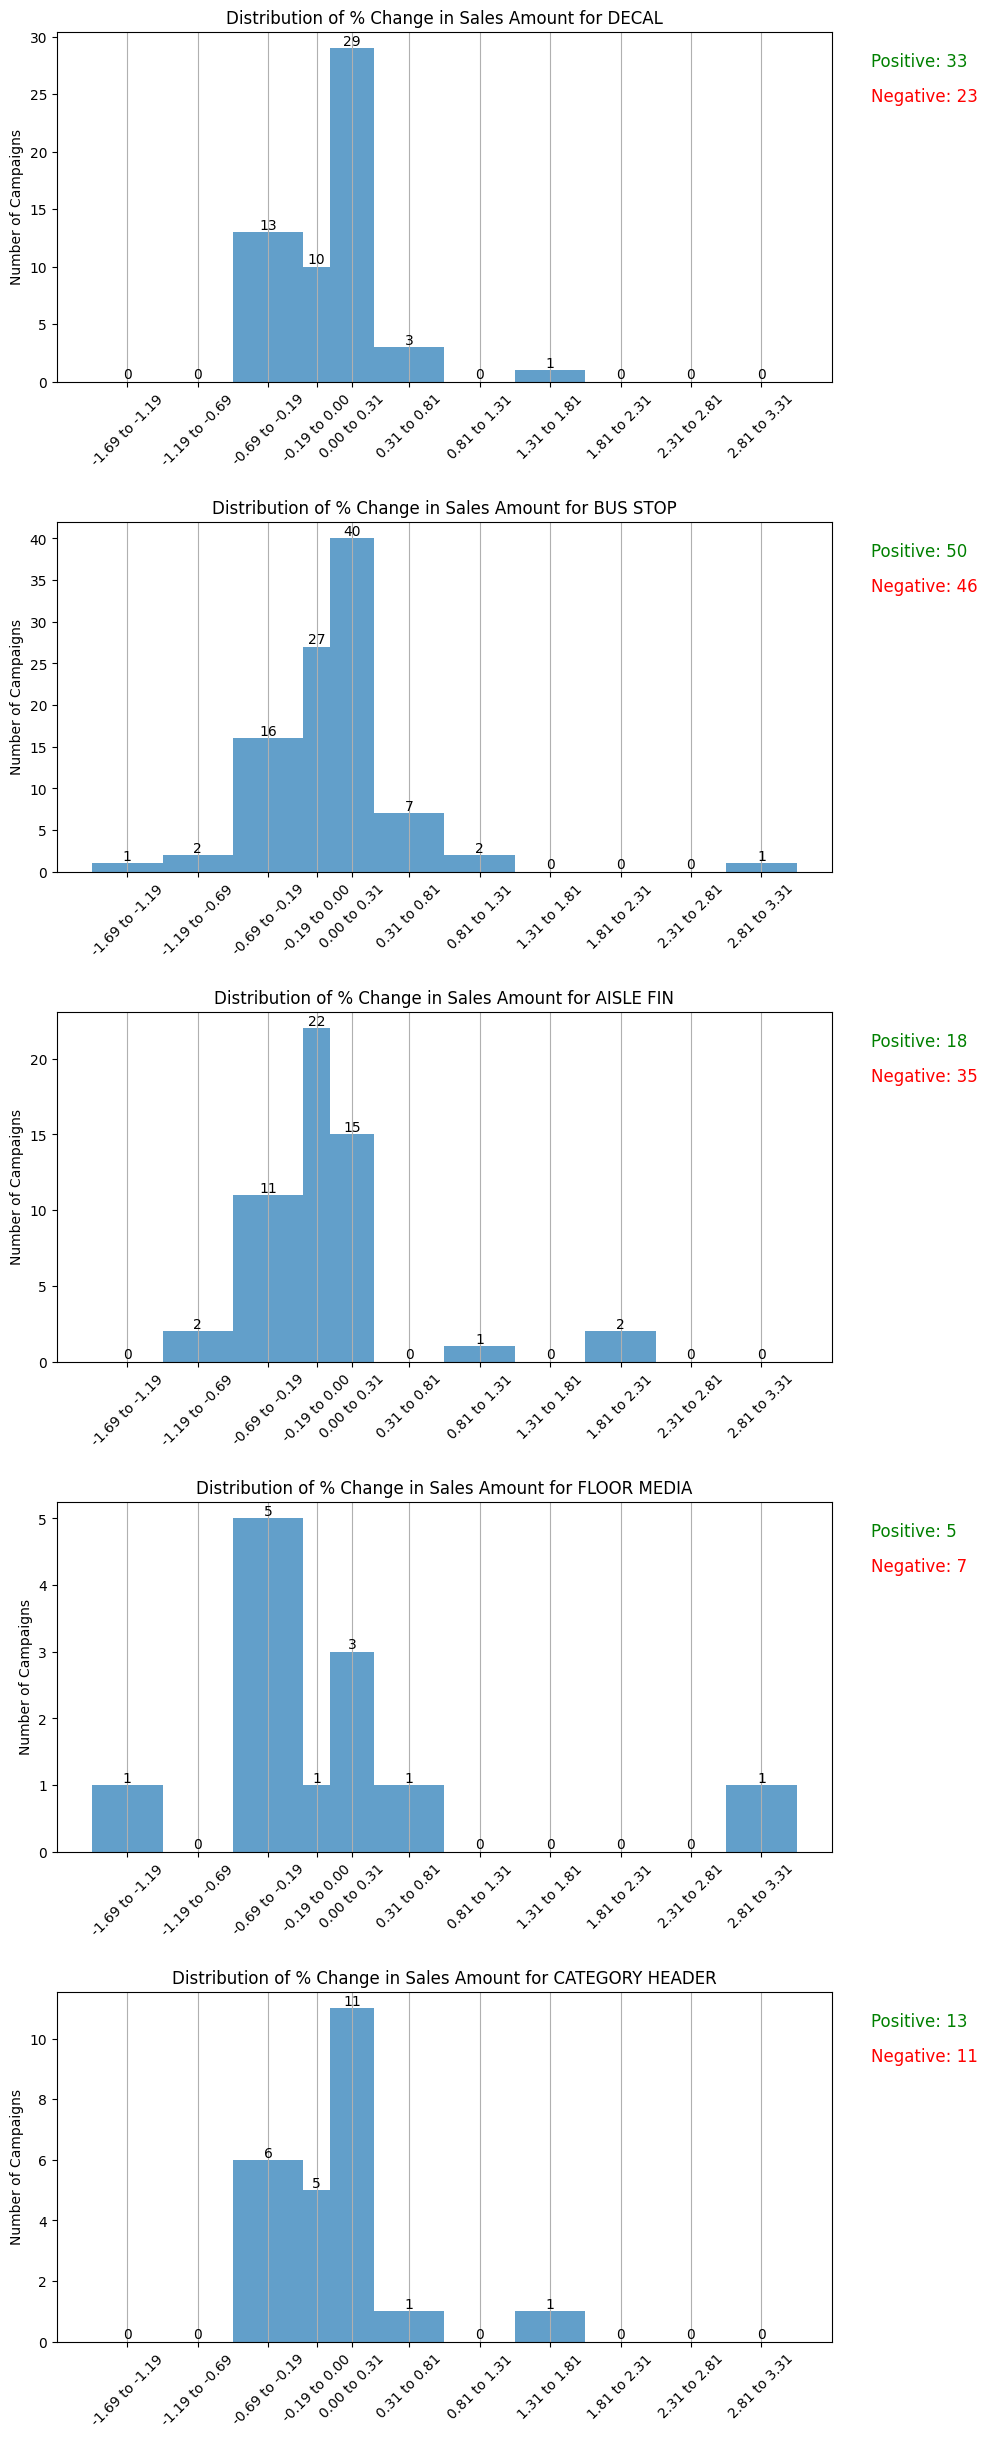

In [236]:
import matplotlib.pyplot as plt

# Plotting histograms
unique_media = check_df['compliant_media'].unique()
num_media = len(unique_media)
df = check_df 

# Identify unique media types
unique_media = df['compliant_media'].unique()

# Identify unique media types
unique_media = df['compliant_media'].unique()

# Convert change_in_sales_amt to float if it isn't already
df['change_in_sales_amt'] = df['change_in_sales_amt'].astype(float)

# Determine the range of the data for bin calculation
min_value = df['change_in_sales_amt'].min()
max_value = df['change_in_sales_amt'].max()

# Define bin edges such that zero is one of the edges
bins = np.arange(min_value, max_value + 0.5, 0.5)  # Add 0.5 to include the maximum value in the range
if 0 not in bins:
    bins = np.append(bins, 0)
bins = np.sort(bins)

# Create subplots
fig, axes = plt.subplots(len(unique_media), 1, figsize=(10, 6 * len(unique_media)), sharex=False)
fig.subplots_adjust(hspace=0.4)

# Ensure axes is always iterable
if len(unique_media) == 1:
    axes = [axes]

# Plot histograms and set ticks
for ax, media in zip(axes, unique_media):
    subset = df[df['compliant_media'] == media]
    counts, bins, patches = ax.hist(subset['change_in_sales_amt'], bins=bins, alpha=0.7)
    ax.set_title(f'Distribution of % Change in Sales Amount for {media}')
    ax.set_ylabel('Number of Campaigns')
    ax.set_xlabel('')
    ax.grid(True, which='both', axis='x')

    # Set ticks to the centers of the bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_labels = [f'{bins[i]:.2f} to {bins[i+1]:.2f}' for i in range(len(bins)-1)]
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(bin_labels, rotation=45)

    # Add frequency labels on top of each bin
    for count, x in zip(counts, bin_centers):
        ax.text(x, count, f'{int(count)}', ha='center', va='bottom')

    # Calculate and display the custom legend
    positive_count = (subset['change_in_sales_amt'] > 0).sum()
    negative_count = (subset['change_in_sales_amt'] < 0).sum()

    # Add custom legend text
    ax.text(1.05, 0.9, f'Positive: {positive_count}', transform=ax.transAxes, color='green', fontsize=12, ha='left')
    ax.text(1.05, 0.8, f'Negative: {negative_count}', transform=ax.transAxes, color='red', fontsize=12, ha='left')

# Show the plot
plt.show()


In [208]:
check = client.query(
    """
SELECT 
    compliant_media, 
    AVG(avg_test_vs_control_perc_change_in_sales_amt) AS change_in_sales_amt,
    AVG(test_vs_control_perc_change_in_transaction_share) AS change_in_transaction_share,
    COUNT(DISTINCT campaign_id) AS n_campaigns
FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results_with_distinct_media_types,
UNNEST(SPLIT(compliant_media_types, ", ")) AS compliant_media 
GROUP BY 1
    """
).result()
check_df = check.to_dataframe()
check_df

,compliant_media,change_in_sales_amt,change_in_transaction_share,n_campaigns
0,DECAL,0.020268512,0.021562,46
1,BUS STOP,0.018835553,0.001471,83
2,AISLE FIN,-0.020197290,0.010066,36
3,FLOOR MEDIA,0.003415608,-0.195459,6
4,CATEGORY HEADER,0.031572496,0.024200,7


In [241]:
check = client.query(
    """
SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_retro_campaign_level_results_with_distinct_media_types 
    """
).result()
check_df = check.to_dataframe()

In [242]:
df = check_df

# Fill NaN values for numerical columns
df['avg_test_vs_control_perc_change_in_sales_amt'] = df['avg_test_vs_control_perc_change_in_sales_amt'].fillna(0)

# Fill NaN values for categorical columns with a placeholder
df['distinct_comparison_non_compliant_media_types'] = df['distinct_comparison_non_compliant_media_types'].fillna('None')
df['subcats'] = df['subcats'].fillna('Unknown')

# Extract unique media types from both test and control
unique_media_types = sorted(set(','.join(pd.concat([df['distinct_compliant_media_types'], df['distinct_comparison_non_compliant_media_types']])).split(',')))

# Create binary indicators for media types in test and control
for media_type in unique_media_types:
    df[f'media_{media_type}_test'] = df['distinct_compliant_media_types'].apply(lambda x: 1 if media_type in x.split(',') else 0)
    df[f'media_{media_type}_control'] = df['distinct_comparison_non_compliant_media_types'].apply(lambda x: 1 if media_type in x.split(',') else 0)

# Drop the original columns
df.drop(columns=['distinct_compliant_media_types', 'distinct_comparison_non_compliant_media_types'], inplace=True)

# Encode categorical variables
df['subcats'] = df['subcats'].astype('category')
df['subcategory_code'] = df['subcats'].cat.codes
df['campaign_code'] = df['campaign_id'].astype('category').cat.codes

In [243]:
df

,campaign_id,subcats,media_types_string,compliant_media_types,comparison_non_compliant_media_types,avg_test_vs_control_perc_change_in_sales_amt,test_vs_control_perc_change_in_transaction_share,n_stores,n_comparison_stores,media_ BUS STOP_test,media_ BUS STOP_control,media_ DECAL_test,media_ DECAL_control,media_ FLOOR MEDIA_test,media_ FLOOR MEDIA_control,media_AISLE FIN_test,media_AISLE FIN_control,media_BUS STOP_test,media_BUS STOP_control,media_CATEGORY HEADER_test,media_CATEGORY HEADER_control,media_DECAL_test,media_DECAL_control,media_FLOOR MEDIA_test,media_FLOOR MEDIA_control,subcategory_code,campaign_code
0,WOW20003478,DAIRY - DIPS,DECAL,DECAL,DECAL,0.192937015,0.421410,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,31,31
1,WOW20003479,DAIRY - DIPS,DECAL,DECAL,DECAL,0.022167456,0.022241,4,4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,31,32
2,WOW20004600,DAIRY - SEAFOOD,DECAL,DECAL,DECAL,0.192743557,0.238522,3,3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,34,47
3,WOW20006845,FREEZER - SNACKING,DECAL,DECAL,DECAL,-0.141254867,-0.074585,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,46,95
4,WOW20005320,FREEZER - AUTHENTIC INDIAN,DECAL,DECAL,DECAL,-0.193801919,0.022912,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,42,63
5,WOW20002328,MILK - FLAVOURED,DECAL,DECAL,DECAL,-0.197899764,-0.196062,5,5,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,59,16
6,WOW20006548,DAIRY - ALTERNATIVE YOGHURT,DECAL,DECAL,DECAL,-0.199950986,-0.168149,15,15,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,26,94
7,WOW20007702,FREEZER - PIZZA,DECAL,DECAL,DECAL,-0.037762180,-0.168341,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,45,107
8,WOW20005747,CHEESE BULK,DECAL,DECAL,DECAL,0.058124491,0.023511,5,5,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,10,76
9,WOW20007960,FREEZER - AUTHENTIC INDIAN,DECAL,DECAL,DECAL,-0.498473518,-0.411744,4,4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,42,112


In [244]:
# Assuming the preprocessed DataFrame is named df
n_campaigns = len(df['campaign_code'].unique())
n_subcategories = len(df['subcategory_code'].unique())
media_columns = [col for col in df.columns if col.startswith('media_') and col.endswith('_test')]

with pm.Model() as model:
    # Hyperpriors for the subcategory-level parameters
    gamma00 = pm.Normal('gamma00', mu=0, sigma=10)
    tau0 = pm.HalfNormal('tau0', sigma=1)
    
    # Subcategory-level intercepts
    subcategory_intercept = pm.Normal('subcategory_intercept', mu=gamma00, sigma=tau0, shape=n_subcategories)
    
    # Coefficients for media types
    media_effects = pm.Normal('media_effects', mu=0, sigma=10, shape=len(media_columns))
    
    # Expected sales
    mu = subcategory_intercept[df['subcategory_code'].values]
    for i, media_col in enumerate(media_columns):
        media_test = df[media_col].values
        media_control = df[media_col.replace('_test', '_control')].values
        mu += media_effects[i] * (media_test - media_control)
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    sales_obs = pm.Normal('sales_obs', mu=mu, sigma=sigma, observed=df['avg_test_vs_control_perc_change_in_sales_amt'])
    
    # Sampling with more tuning and higher target_accept to reduce divergences
    trace = pm.sample(3000, tune=2000, target_accept=0.99, random_seed=42)

# Summary of the posterior distribution
summary = az.summary(trace)

# Extracting point estimates and credibility intervals for subcategory intercepts
subcategory_intercepts_df = pd.DataFrame({
    'mean': summary.loc[summary.index.str.startswith('subcategory_intercept'), 'mean'],
    'hdi_3%': summary.loc[summary.index.str.startswith('subcategory_intercept'), 'hdi_3%'],
    'hdi_97%': summary.loc[summary.index.str.startswith('subcategory_intercept'), 'hdi_97%']
})

# Extracting point estimates and credibility intervals for media effects
media_effects_df = pd.DataFrame({
    'mean': summary.loc[summary.index.str.startswith('media_effects'), 'mean'],
    'hdi_3%': summary.loc[summary.index.str.startswith('media_effects'), 'hdi_3%'],
    'hdi_97%': summary.loc[summary.index.str.startswith('media_effects'), 'hdi_97%']
})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma00, tau0, subcategory_intercept, media_effects, sigma]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


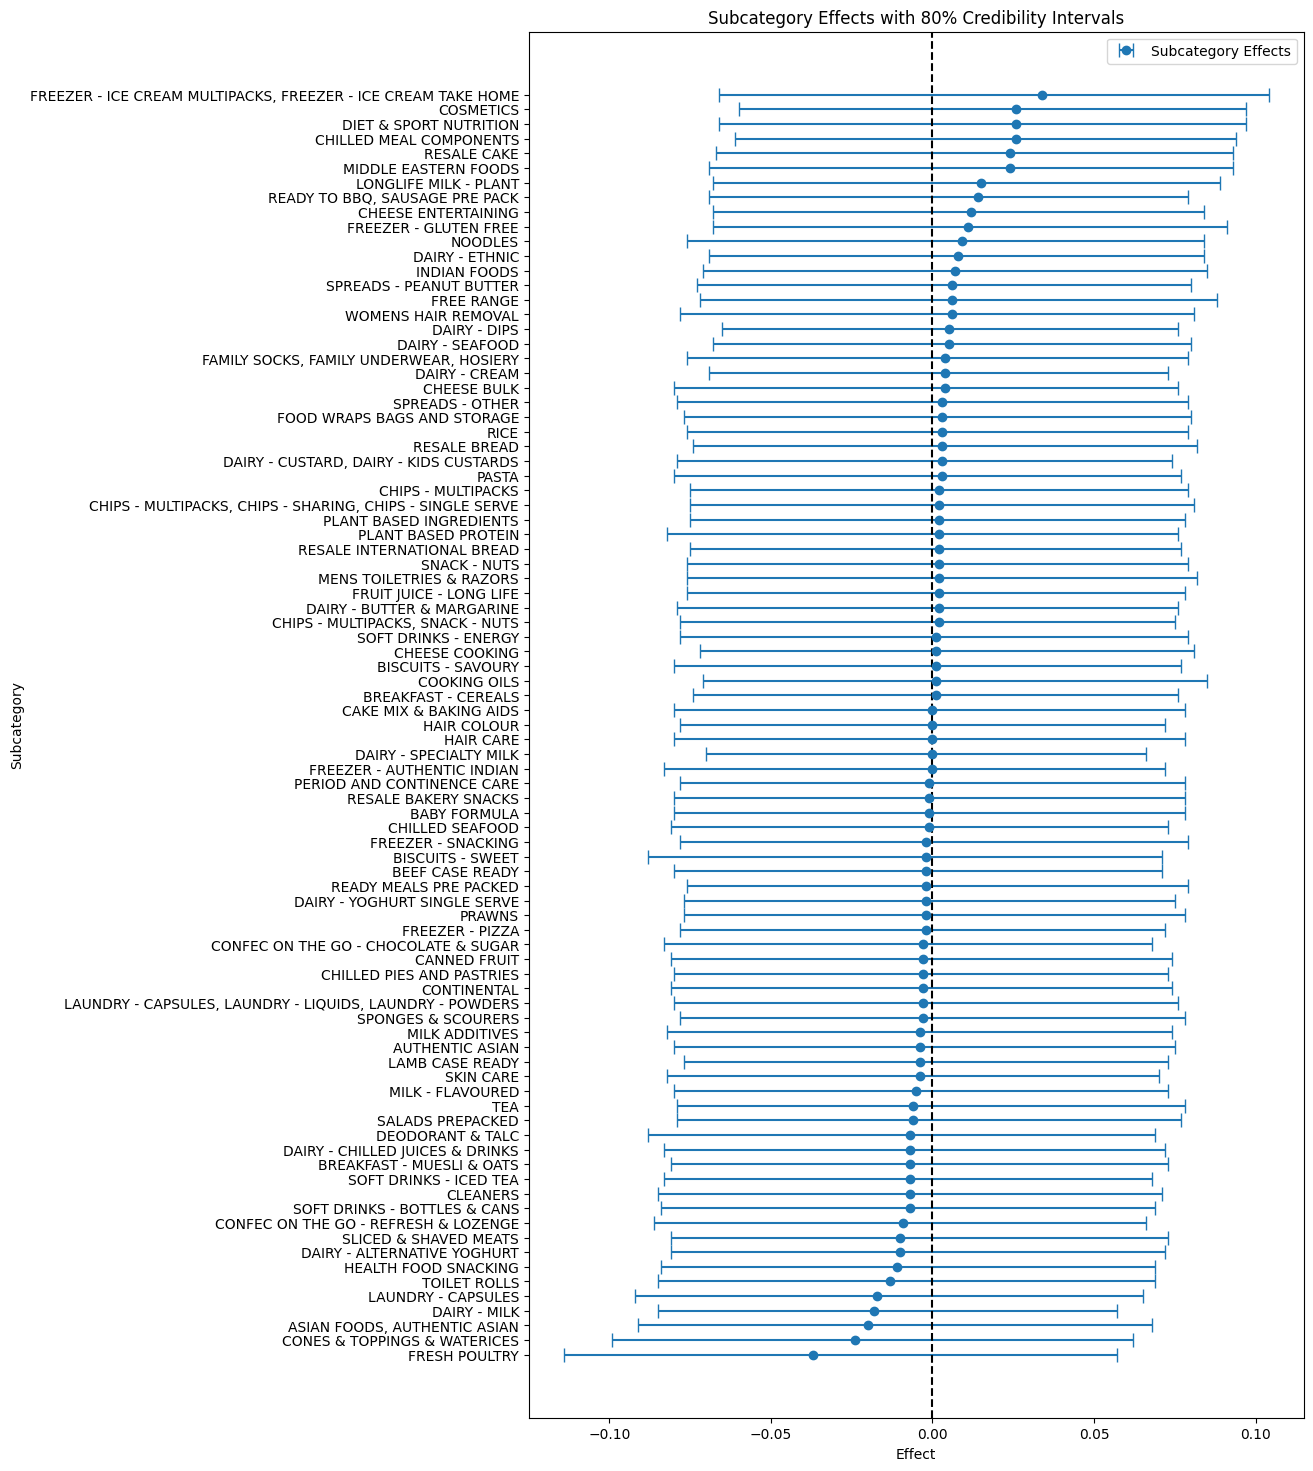

In [245]:

# Assuming you have the trace object from PyMC3
# Example: summary statistics extraction
summary = az.summary(trace, hdi_prob=0.80)

# Extracting point estimates and 80% credibility intervals for subcategory intercepts
subcategory_intercepts_df = pd.DataFrame({
    'mean': summary.loc[summary.index.str.startswith('subcategory_intercept'), 'mean'],
    'hdi_10%': summary.loc[summary.index.str.startswith('subcategory_intercept'), 'hdi_10%'],  # Lower bound of 80% interval
    'hdi_90%': summary.loc[summary.index.str.startswith('subcategory_intercept'), 'hdi_90%']   # Upper bound of 80% interval
})

# Mapping subcategory names to their original indices
subcategory_names = [name for name in df['subcats'].cat.categories if name in df['subcats'].unique()]
subcategory_indices = df['subcats'].cat.codes.unique()

# Creating a DataFrame to map subcategory names to their summary statistics
subcategory_stats = pd.DataFrame({
    'name': subcategory_names,
    'mean': subcategory_intercepts_df['mean'].values,
    'hdi_10%': subcategory_intercepts_df['hdi_10%'].values,
    'hdi_90%': subcategory_intercepts_df['hdi_90%'].values
})

# Sorting subcategories by point estimates (means) from highest to lowest
subcategory_stats = subcategory_stats.sort_values(by='mean', ascending=False)

# Plotting subcategory effects horizontally, sorted by point estimates
plt.figure(figsize=(10, 18))
plt.errorbar(subcategory_stats['mean'], subcategory_stats['name'], 
             xerr=[subcategory_stats['mean'] - subcategory_stats['hdi_10%'], 
                   subcategory_stats['hdi_90%'] - subcategory_stats['mean']], 
             fmt='o', capsize=5, label='Subcategory Effects')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)  # Adding a bold vertical line at zero
plt.ylabel('Subcategory')
plt.xlabel('Effect')
plt.title('Subcategory Effects with 80% Credibility Intervals')
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top
plt.show()

In [272]:

# Assuming the preprocessed DataFrame is named df
n_campaigns = len(df['campaign_code'].unique())
n_subcategories = len(df['subcategory_code'].unique())

with pm.Model() as model:
    # Hyperpriors for the subcategory-level parameters
    gamma00 = pm.Normal('gamma00', mu=0, sigma=10)
    tau0 = pm.HalfNormal('tau0', sigma=1)
    
    # Subcategory-level intercepts
    subcategory_intercept = pm.Normal('subcategory_intercept', mu=gamma00, sigma=tau0, shape=n_subcategories)
    
    # Coefficients for media types
    media_effects = pm.Normal('media_effects', mu=0, sigma=10, shape=len(media_columns))
    
    # Expected sales
    mu = subcategory_intercept[df['subcategory_code'].values]
    for i, media_col in enumerate(media_columns):
        media_test = df[media_col].values
        media_control = df[media_col.replace('_test', '_control')].values
        mu += media_effects[i] * (media_test - media_control)
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    sales_obs = pm.Normal('sales_obs', mu=mu, sigma=sigma, observed=df['avg_test_vs_control_perc_change_in_sales_amt'])
    
    # Sampling with more tuning and higher target_accept to reduce divergences
    trace = pm.sample(3000, tune=2000, target_accept=0.99, random_seed=42)

# Summary of the posterior distribution
summary = az.summary(trace, hdi_prob=0.80)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma00, tau0, subcategory_intercept, media_effects, sigma]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 36 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


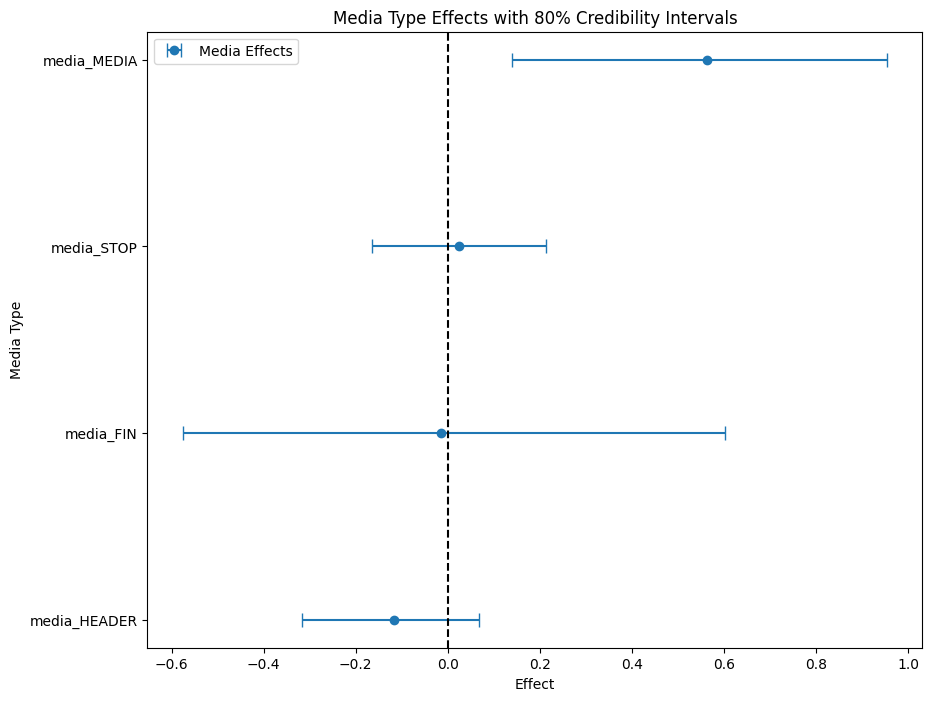

In [274]:
# Extracting point estimates and 80% credibility intervals for media effects
media_effects_df = pd.DataFrame({
    'mean': summary.loc[summary.index.str.startswith('media_effects'), 'mean'],
    'hdi_10%': summary.loc[summary.index.str.startswith('media_effects'), 'hdi_10%'],  # Lower bound of 80% interval
    'hdi_90%': summary.loc[summary.index.str.startswith('media_effects'), 'hdi_90%']   # Upper bound of 80% interval
})

# Mapping media type names to their original indices, ensuring no leading/trailing whitespace
media_names = [col.replace('_test', '').strip() for col in media_columns]

# Creating a DataFrame to map media type names to their summary statistics
media_stats = pd.DataFrame({
    'name': media_names,
    'mean': media_effects_df['mean'].values,
    'hdi_10%': media_effects_df['hdi_10%'].values,
    'hdi_90%': media_effects_df['hdi_90%'].values
})

# Removing any potential duplicates
media_stats = media_stats.groupby('name').agg({
    'mean': 'mean',
    'hdi_10%': 'mean',  # Taking mean for aggregation purposes
    'hdi_90%': 'mean'   # Taking mean for aggregation purposes
}).reset_index()

# Sorting media types by point estimates (means) from highest to lowest
media_stats = media_stats.sort_values(by='mean', ascending=False)
# List of media types to exclude
exclude_media_types = ["media_ FLOOR MEDIA", "media_ DECAL", "media_ BUS STOP"]

# List of media types to exclude
exclude_media_types = ["media_ FLOOR MEDIA", "media_ DECAL", "media_ BUS STOP"]

# Filter the media_stats DataFrame to exclude specific media types
filtered_media_stats = media_stats[~media_stats['name'].isin(exclude_media_types)]

# Plotting media effects horizontally, sorted by point estimates
plt.figure(figsize=(10, 8))
plt.errorbar(media_stats['mean'], media_stats['name'], 
             xerr=[media_stats['mean'] - media_stats['hdi_10%'], 
                   media_stats['hdi_90%'] - media_stats['mean']], 
             fmt='o', capsize=5, label='Media Effects')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)  # Adding a bold vertical line at zero
plt.ylabel('Media Type')
plt.xlabel('Effect')
plt.title('Media Type Effects with 80% Credibility Intervals')
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top
plt.show()


In [271]:
media_stats

,name,mean,hdi_10%,hdi_90%
2,media_ FLOOR MEDIA,1.240,0.821,1.662
7,media_FLOOR MEDIA,0.960,-4.770,6.685
6,media_DECAL,0.738,-5.220,6.234
1,media_ DECAL,0.561,0.245,0.881
5,media_CATEGORY HEADER,-0.060,-5.628,5.837
3,media_AISLE FIN,-0.151,-6.006,5.462
0,media_ BUS STOP,-0.259,-0.484,-0.050
4,media_BUS STOP,-0.418,-6.002,5.462


In [ ]:
# Extracting point estimates and 80% credibility intervals for media effects
media_effects_df = pd.DataFrame({
    'mean': summary.loc[summary.index.str.startswith('media_effects'), 'mean'],
    'hdi_10%': summary.loc[summary.index.str.startswith('media_effects'), 'hdi_10%'],  # Lower bound of 80% interval
    'hdi_90%': summary.loc[summary.index.str.startswith('media_effects'), 'hdi_90%']   # Upper bound of 80% interval
})

# Mapping media type names to their original indices, ensuring no leading/trailing whitespace
media_names = [col.replace('_test', '').strip() for col in media_columns]

# Creating a DataFrame to map media type names to their summary statistics
media_stats = pd.DataFrame({
    'name': media_names,
    'mean': media_effects_df['mean'].values,
    'hdi_10%': media_effects_df['hdi_10%'].values,
    'hdi_90%': media_effects_df['hdi_90%'].values
})

# Aggregating media effects by name to ensure no duplicates due to whitespace issues
media_stats = media_stats.groupby('name').agg({
    'mean': 'mean',
    'hdi_10%': 'mean',  # Taking mean for aggregation purposes
    'hdi_90%': 'mean'   # Taking mean for aggregation purposes
}).reset_index()

# Sorting media types by point estimates (means) from highest to lowest
media_stats = media_stats.sort_values(by='mean', ascending=False)

# Plotting media effects horizontally, sorted by point estimates
plt.figure(figsize=(10, 8))
plt.errorbar(media_stats['mean'], media_stats['name'], 
             xerr=[media_stats['mean'] - media_stats['hdi_10%'], 
                   media_stats['hdi_90%'] - media_stats['mean']], 
             fmt='o', capsize=5, label='Media Effects')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)  # Adding a bold vertical line at zero
plt.ylabel('Media Type')
plt.xlabel('Effect')
plt.title('Media Type Effects with 80% Credibility Intervals')
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top
plt.show()

In [112]:
# Extracting the global mean (gamma00) from the summary
if 'gamma00' in summary.index:
    global_mean = summary.loc['gamma00', 'mean']
    global_hdi_10 = summary.loc['gamma00', 'hdi_10%']
    global_hdi_90 = summary.loc['gamma00', 'hdi_90%']
    
    print(f"Global Mean (gamma00): {global_mean}")
    print(f"80% Credibility Interval for Global Mean: [{global_hdi_10}, {global_hdi_90}]")
else:
    print("gamma00 not found in the summary index.")

Global Mean (gamma00): -0.002
80% Credibility Interval for Global Mean: [-0.044, 0.04]


In [124]:
# Constants for margin of error calculation
Z_90 = 1.645
sigma = 0.5

# Function to calculate campaign durations and margins for different effect sizes
def calculate_campaign_durations_and_margins_corrected(sales_volumes, control_stores_list, effect_size, Z, sigma):
    results = {
        "Sales Volume (units per store per day)": [],
        "Effect Size": [],
        "Control Stores": [],
        "Duration [days]": [],
        "Margin of Error": []
    }
    
    for control_stores in control_stores_list:
        required_sample_size = ((Z + 0.84) / effect_size) ** 2 * 2 * sigma ** 2
        for daily_units in sales_volumes:
            total_units_control = daily_units * control_stores
            campaign_duration = required_sample_size / total_units_control
            n = daily_units * control_stores * campaign_duration  # total sample size
            margin_of_error = Z * (sigma / np.sqrt(n))
            results["Sales Volume (units per store per day)"].append(daily_units)
            results["Effect Size"].append(effect_size * 100)  # as percentage
            results["Control Stores"].append(control_stores)
            results["Duration [days]"].append(campaign_duration)
            results["Margin of Error"].append(margin_of_error)
    
    return pd.DataFrame(results)

# Sales volume categories (units per store per day) and control stores list
sales_volumes = [4, 10, 20, 40, 60, 80, 100, 120, 140, 160]
control_stores_list = [20, 30, 40, 60, 80, 100]

# Calculate campaign durations and margins for 1%, 2%, and 3% effect sizes with different control stores at 90% power
df_1pct = calculate_campaign_durations_and_margins_corrected(sales_volumes, control_stores_list, 0.01, Z_90, sigma)
df_2pct = calculate_campaign_durations_and_margins_corrected(sales_volumes, control_stores_list, 0.02, Z_90, sigma)
df_3pct = calculate_campaign_durations_and_margins_corrected(sales_volumes, control_stores_list, 0.03, Z_90, sigma)

# Combine all results into one DataFrame
results_combined_df = pd.concat([df_1pct, df_2pct, df_3pct], ignore_index=True)
results_combined_df

,Sales Volume (units per store per day),Effect Size,Control Stores,Duration [days],Margin of Error
0,4,1.0,20,385.951562,0.004681
1,10,1.0,20,154.380625,0.004681
2,20,1.0,20,77.190312,0.004681
3,40,1.0,20,38.595156,0.004681
4,60,1.0,20,25.730104,0.004681
5,80,1.0,20,19.297578,0.004681
6,100,1.0,20,15.438062,0.004681
7,120,1.0,20,12.865052,0.004681
8,140,1.0,20,11.027187,0.004681
9,160,1.0,20,9.648789,0.004681


In [125]:
# Constants for margin of error calculation
Z_90 = 1.645
sigma = 0.5
desired_margin_of_error = 0.01 / 100  # 0.01% in decimal form

# Calculate the required sample size for the desired margin of error
required_sample_size = (Z_90 * sigma / desired_margin_of_error) ** 2

# Function to calculate campaign durations and margins for different effect sizes with the new sample size
def calculate_campaign_durations_and_margins_new(sales_volumes, control_stores_list, effect_size, Z, sigma, required_sample_size):
    results = {
        "Sales Volume (units per store per day)": [],
        "Effect Size": [],
        "Control Stores": [],
        "Duration [days]": [],
        "Margin of Error": []
    }
    
    for control_stores in control_stores_list:
        for daily_units in sales_volumes:
            total_units_control = daily_units * control_stores
            campaign_duration = required_sample_size / total_units_control
            n = daily_units * control_stores * campaign_duration  # total sample size
            margin_of_error = Z * (sigma / np.sqrt(n))
            results["Sales Volume (units per store per day)"].append(daily_units)
            results["Effect Size"].append(effect_size * 100)  # as percentage
            results["Control Stores"].append(control_stores)
            results["Duration [days]"].append(campaign_duration)
            results["Margin of Error"].append(margin_of_error)
    
    return pd.DataFrame(results)

# Sales volume categories (units per store per day) and control stores list
sales_volumes = [4, 10, 20, 40, 60, 80, 100, 120, 140, 160]
control_stores_list = [20, 30, 40, 60, 80, 100]

# Calculate campaign durations and margins for 1% effect size with the new required sample size at 90% power
df_new = calculate_campaign_durations_and_margins_new(sales_volumes, control_stores_list, 0.01, Z_90, sigma, required_sample_size)

# Display the dataframe to the user
df_new

,Sales Volume (units per store per day),Effect Size,Control Stores,Duration [days],Margin of Error
0,4,1.0,20,845632.812500,0.0001
1,10,1.0,20,338253.125000,0.0001
2,20,1.0,20,169126.562500,0.0001
3,40,1.0,20,84563.281250,0.0001
4,60,1.0,20,56375.520833,0.0001
5,80,1.0,20,42281.640625,0.0001
6,100,1.0,20,33825.312500,0.0001
7,120,1.0,20,28187.760417,0.0001
8,140,1.0,20,24160.937500,0.0001
9,160,1.0,20,21140.820312,0.0001


In [ ]:
check = client.query(
    """ 
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_campaign_impact AS
with step_one AS (
    SELECT 
        logs.campaign_id,
        MAX(query_step) AS latest_step, 
        MIN(query_start_time) AS run_start_time,
        MAX(query_end_time) AS run_end_time, 
        MAX(query_duration_in_seconds) AS query_duration_in_seconds,
        MAX(query_duration_in_minutes) AS query_duration_in_minutes,
    FROM `gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_run_logs` logs
    WHERE DATE(query_end_time) = DATE("2024-06-09")
    AND query_end_time >= "2024-06-09 18:07:39.062239"
    AND query_step = "7"
    GROUP BY 1
)
,step_two AS (
    SELECT 
        pre.campaign_id, 
        campaigns.campaign_start_date,
        campaigns.campaign_end_date,
        pre.store_id, 
        pre.subcats,
        pre.media_types_string, 
        pre.compliant_media_types,
        pre.non_compliant_media_types, 
        ARRAY_TO_STRING(pre.campaign_skus, ", ") AS campaign_skus, 
        
        pre.n_days_pre_period,
        during.n_days_campaign_period,
        post.n_days_post_period,
        
        pre.total_sales_pre_period, 
        during.total_sales_campaign_period,
        post.total_sales_post_period,
        
        pre.total_baskets_pre_period,
        during.total_baskets_campaign_period,
        post.total_baskets_post_period,

        SAFE_DIVIDE(pre.total_sales_pre_period, 7) AS pre_period_daily_avg_sales, 
        SAFE_DIVIDE(during.total_sales_campaign_period, 7) AS campaign_period_daily_avg_sales,
        SAFE_DIVIDE(post.total_sales_post_period, 7) AS post_period_daily_avg_sales, 

        
        
        SAFE_DIVIDE(pre.total_baskets_pre_period, 7) AS pre_period_daily_avg_baskets,  
        SAFE_DIVIDE(during.total_baskets_campaign_period, 7) AS campaign_period_daily_avg_baskets, 
        SAFE_DIVIDE(post.total_baskets_post_period, 7) AS post_period_daily_avg_baskets,

        all_baskets_with_or_without_promoted_skus_pre_campaign,
        all_baskets_with_or_without_promoted_skus_during_campaign,
        all_baskets_with_or_without_promoted_skus_post_campaign, 

        SAFE_DIVIDE(total_baskets_pre_period , all_baskets_with_or_without_promoted_skus_pre_campaign) AS perc_baskets_with_item_pre_campaign,
        SAFE_DIVIDE(total_baskets_campaign_period , all_baskets_with_or_without_promoted_skus_during_campaign) AS perc_baskets_with_item_during_campaign,
        SAFE_DIVIDE(total_baskets_post_period , all_baskets_with_or_without_promoted_skus_post_campaign) AS perc_baskets_with_item_post_campaign


        --discount_depth_pre,
        --discount_depth_during,
        --discount_depth_post
    
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_four_pre_campaign_sales pre

    LEFT JOIN (SELECT DISTINCT booking_number, campaign_start_date, campaign_end_date FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`) campaigns 
        ON pre.campaign_id = campaigns.booking_number 
        AND pre.campaign_start_date = campaigns.campaign_start_date     
    
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_five_during_campaign_sales during 
        ON pre.campaign_id = during.campaign_id 
        AND pre.store_id = during.store_id

    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_six_post_campaign_sales post 
        ON pre.campaign_id = post.campaign_id 
        AND pre.store_id = post.store_id


    /*
    LEFT JOIN (
        SELECT 
            pre.campaign_id, 
            pre.store_id,
            (AVG(pre_discount.retailunitprice) - (SUM(pre_discount.retailamount) / SUM(pre_discount.retailquantity))) / AVG(pre_discount.retailunitprice) AS discount_depth_pre
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_four_pre_campaign_sales pre
        LEFT JOIN (SELECT DISTINCT booking_number, campaign_start_date, campaign_end_date FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`) campaigns 
            ON pre.campaign_id = campaigns.booking_number 
            AND pre.campaign_start_date = campaigns.campaign_start_date    

        LEFT JOIN `gcp-wow-cart-data-prod-d710.staging_transformation.smkt_pos_item_line_detail_crn` pre_discount
            ON pre_discount.sitenumber = pre.store_id 
            AND DATE(pre_discount.txnstarttimestamp) BETWEEN (campaigns.campaign_start_date -7) AND (campaigns.campaign_start_date -1)
        WHERE pre.campaign_id = "WOW20000360"
        AND pre_discount.article = "88436"
        AND DATE(pre_discount.txnstarttimestamp) BETWEEN (campaigns.campaign_start_date -7) AND (campaigns.campaign_start_date -1)
        GROUP BY 1,2
    ) pre_discount 
        ON pre_discount.campaign_id = pre.campaign_id 
        AND pre_discount.store_id = pre.store_id
        
    LEFT JOIN (
        SELECT 
            pre.campaign_id, 
            pre.store_id,
            (AVG(during_discount.retailunitprice) - (SUM(during_discount.retailamount) / SUM(during_discount.retailquantity))) / AVG(during_discount.retailunitprice) AS discount_depth_during
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_four_pre_campaign_sales pre
        LEFT JOIN (SELECT DISTINCT booking_number, campaign_start_date, campaign_end_date FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`) campaigns 
            ON pre.campaign_id = campaigns.booking_number 
            AND pre.campaign_start_date = campaigns.campaign_start_date    

        LEFT JOIN `gcp-wow-cart-data-prod-d710.staging_transformation.smkt_pos_item_line_detail_crn` during_discount
            ON during_discount.sitenumber = pre.store_id 
            AND DATE(during_discount.txnstarttimestamp) BETWEEN (campaigns.campaign_start_date) AND (campaigns.campaign_end_date)
        WHERE pre.campaign_id = "WOW20000360"
        AND during_discount.article = "88436"
        AND DATE(during_discount.txnstarttimestamp) BETWEEN (campaigns.campaign_start_date) AND (campaigns.campaign_end_date)
        GROUP BY 1,2
    ) during_discount 
        ON during_discount.campaign_id = pre.campaign_id 
        AND during_discount.store_id = pre.store_id

    LEFT JOIN (
        SELECT 
            pre.campaign_id, 
            pre.store_id,
            (AVG(post_discount.retailunitprice) - (SUM(post_discount.retailamount) / SUM(post_discount.retailquantity))) / AVG(post_discount.retailunitprice) AS discount_depth_post
        FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_four_pre_campaign_sales pre
        LEFT JOIN (SELECT DISTINCT booking_number, campaign_start_date, campaign_end_date FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`) campaigns 
            ON pre.campaign_id = campaigns.booking_number 
            AND pre.campaign_start_date = campaigns.campaign_start_date    

        LEFT JOIN `gcp-wow-cart-data-prod-d710.staging_transformation.smkt_pos_item_line_detail_crn` post_discount
            ON post_discount.sitenumber = pre.store_id 
            AND DATE(post_discount.txnstarttimestamp) BETWEEN (campaigns.campaign_end_date + 1) AND (campaigns.campaign_end_date + 7)
        WHERE pre.campaign_id = "WOW20000360"
        AND post_discount.article = "88436"
        AND DATE(post_discount.txnstarttimestamp) BETWEEN (campaigns.campaign_end_date + 1) AND (campaigns.campaign_end_date + 7)
        GROUP BY 1,2
    ) post_discount 
        ON post_discount.campaign_id = pre.campaign_id 
        AND post_discount.store_id = pre.store_id
    */

    

    WHERE pre.campaign_id IN (SELECT DISTINCT campaign_id FROM step_one)

    --ORDER BY pre.campaign_id, pre.store_id
),
step_three AS (
SELECT *,  
    SAFE_DIVIDE(total_sales_campaign_period , total_sales_pre_period) -1 AS perc_change_in_sales,
    SAFE_DIVIDE(perc_baskets_with_item_during_campaign , perc_baskets_with_item_pre_campaign) -1 AS perc_change_in_transaction_share
FROM step_two 
)
SELECT 
    step_three.campaign_id,
    step_three.campaign_start_date,
    step_three.store_id, 
    step_three.perc_change_in_sales,
    step_three.perc_change_in_transaction_share,
    comparison.comparison_store_id,
    comparison.comparison_perc_change_in_sales,
    comparison.comparison_perc_change_in_transaction_share,
    ABS(step_three.perc_change_in_sales - comparison.comparison_perc_change_in_sales) AS abs_diff_perc_change_in_sales,
    ABS(step_three.perc_change_in_transaction_share - comparison.comparison_perc_change_in_transaction_share) AS abs_diff_perc_change_in_transaction_share
FROM step_three
LEFT JOIN (
    SELECT DISTINCT 
        step_three.campaign_id,
        step_three.store_id AS comparison_store_id, 
        step_three.perc_change_in_sales AS comparison_perc_change_in_sales,
        step_three.perc_change_in_transaction_share AS comparison_perc_change_in_transaction_share
    FROM step_three
) comparison 
    ON comparison.campaign_id = step_three.campaign_id 
    AND comparison.comparison_store_id <> step_three.store_id 
ORDER BY campaign_id, store_id, abs_diff_perc_change_in_sales

/*
, step_three AS (
    SELECT 
        campaign_id,
        ARRAY_AGG(DISTINCT am.ArticleDescription IGNORE NULLS) AS products,
        AVG(total_baskets_pre_period) AS avg_baskets_pre_period,
        AVG(total_baskets_campaign_period) AS avg_baskets_campaign_period,
        AVG(total_baskets_post_period) AS avg_baskets_post_period,
        SUM(total_sales_pre_period) AS total_sales_pre,
        SUM(total_sales_campaign_period) AS total_sales_campaign,
        SUM(total_sales_post_period) AS total_sales_post
    FROM step_two,
    UNNEST(SPLIT(campaign_skus, ", ")) AS sku 
    LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am 
        ON am.Article = sku 
    WHERE am.SalesOrg = 1005
    GROUP BY 1
) 
SELECT * FROM step_three ORDER BY total_sales_campaign - total_sales_pre DESC
*/
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [163]:
check = client.query(
    """ 
   CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control AS (
    with campaign_info AS (
        SELECT  
            booking_number, 
            line_name, 
            CASE 
                WHEN ca.compliance_media_type LIKE '%AISLE FIN%' THEN 'AISLE FIN' 
                WHEN ca.compliance_media_type LIKE '%BUS STOP%' THEN 'BUS STOP'
                WHEN ca.compliance_media_type LIKE '%CATEGORY HEADER%' THEN 'CATEGORY HEADER'
                WHEN ca.compliance_media_type LIKE '%DECAL%' THEN 'DECAL'
                WHEN ca.compliance_media_type LIKE '%FLOOR MEDIA%' THEN 'FLOOR MEDIA' 
                ELSE 'OTHERS' 
                END AS media_type, 
            ca.campaign_start_date,
            ca.campaign_end_date,
            ca.media_start_date, 
            ca.media_end_date, 
            CASE WHEN co.week_number = "Installation" THEN ca.media_start_date ELSE DATE_ADD(ca.media_start_date, INTERVAL (CAST(SUBSTR(week_number, LENGTH(week_number)) AS INT64) -1) WEEK) END AS media_run_week_start_date,
            CASE WHEN co.week_number = "Installation" THEN 1 ELSE CAST(SUBSTR(week_number, LENGTH(week_number)) AS INT64) END AS week_number,
            quoteline_sku,
            ARRAY_AGG(DISTINCT prod_category IGNORE NULLS ORDER BY prod_category) AS categories, 
            ARRAY_AGG(DISTINCT subcat IGNORE NULLS ORDER BY subcat) AS subcats, 
            COUNT(DISTINCT store_id) AS n_stores,
            COUNT(DISTINCT CASE WHEN result = 1 THEN store_id ELSE NULL END) AS n_compliant_stores,
            COUNT(DISTINCT CASE WHEN result = 0 THEN store_id ELSE NULL END) AS n_non_compliant_stores
        FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` ca, 
        UNNEST(SPLIT(quoteline_sku, ",")) AS individual_sku

        LEFT JOIN (
            SELECT DISTINCT
                am.Article, 
                am.ArticleDescription,
                CategoryDescription AS prod_category,
                Sub_CategoryDescription AS subcat     
            FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_masterdata_view.dim_article_master_v` am
            INNER JOIN (
                SELECT DISTINCT 
                    Article 
                FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass 
                WHERE TXNStartDate >= DATE("2023-01-01") 
                AND SalesOrg = 1005
                AND TotalAmountIncldTax > 0
            ) articles_sold_since_2023 ON articles_sold_since_2023.Article = am.Article
            WHERE SalesOrg = 1005
            AND Sub_CategoryDescription <> "" 
            AND Sub_CategoryDescription IS NOT NULL 
        ) article_subcats ON article_subcats.Article = individual_sku

        LEFT JOIN `gcp-wow-cart-data-prod-d710.cdm.fact_compass_activity` co
            ON ca.booking_number = co.campaign_id 
            AND ca.line_name = co.quote_line 
        
        WHERE   
            ca.campaign_start_date >= DATE("2023-01-01") 
        AND 
            ca.campaign_end_date < CURRENT_DATE()  
        AND 
            ca.booking_number LIKE "%WOW%"
        AND 
            co.missing_record_flag = 0
        AND 
            (
                UPPER(ca.media_type) LIKE '%SCREEN%' 
                OR 
                ca.media_location IN ('Category','Aisle','Store') 
                OR 
                LOWER(ca.media_type) LIKE '%bus stop%'
            )

        GROUP BY 1,2,3,4,5,6,7,8,9,10
    ),

    campaigns_with_non_instore_assets AS (
        SELECT DISTINCT 
            booking_number AS campaign_id 
        FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`
        WHERE 
            booking_number LIKE "%WOW%"
        AND     
            campaign_start_date >= DATE("2023-01-01") 
        AND 
            campaign_end_date < CURRENT_DATE()  
        AND 
            (
               UPPER(media_type) NOT LIKE '%SCREEN%' 
               AND 
               media_location NOT IN ('Category','Aisle','Store') 
               AND 
               LOWER(media_type) NOT LIKE '%bus stop%' 
            )
    ),
    overlapping_campaigns AS (
        SELECT 
            instore_only_campaigns_and_skus.*,
            campaign_info.week_number,
            campaign_info.n_stores,
            campaign_info.n_compliant_stores,
            campaign_info.n_non_compliant_stores,
            CASE WHEN campaigns_with_non_instore_assets.campaign_id IS NULL THEN 1 ELSE 0 END AS instore_only,
                CASE
                    WHEN EXISTS (
                        SELECT 1
                        FROM UNNEST(SPLIT(instore_only_campaigns_and_skus.subcats, ", ")) AS val1
                        JOIN UNNEST(SPLIT(adjacent_campaigns.subcats, ", ")) AS val2
                        ON val1 = val2
                        AND val1 IS NOT NULL AND val2 IS NOT NULL 
                        AND val1 <> "" AND val2 <> ""
                    ) 
                    THEN 1
                    ELSE 0
                END AS matching_subcat_flag,
                ARRAY_AGG(DISTINCT adjacent_campaigns.booking_number IGNORE NULLS) AS overlapping_campaign_ids
            
            -- Instore Campaigns
            FROM (
                SELECT DISTINCT 
                    booking_number, 
                    campaign_start_date,
                    campaign_end_date,
                    line_name,
                    media_type,
                    quoteline_sku,
                    media_start_date, 
                    media_end_date, 
                    media_run_week_start_date,
                    ARRAY_TO_STRING(subcats, ", ") AS subcats,
                    ARRAY_TO_STRING(categories, ", ") AS categories
                FROM campaign_info
            ) instore_only_campaigns_and_skus

            -- Adjacent Campaigns
            LEFT JOIN (
                SELECT DISTINCT 
                    booking_number, 
                    media_start_date, 
                    media_end_date, 
                    media_run_week_start_date,
                    ARRAY_TO_STRING(subcats, ", ") AS subcats,
                    ARRAY_TO_STRING(categories, ", ") AS categories
                FROM campaign_info
            ) AS adjacent_campaigns 
        
        ON 
        
        -- Different campaign
        instore_only_campaigns_and_skus.booking_number <> adjacent_campaigns.booking_number 

        AND 

        -- Join only if media_start_date overlaps
        instore_only_campaigns_and_skus.media_run_week_start_date = adjacent_campaigns.media_run_week_start_date 

        LEFT JOIN campaign_info 
            ON campaign_info.booking_number = instore_only_campaigns_and_skus.booking_number 
            AND campaign_info.line_name = instore_only_campaigns_and_skus.line_name 
            AND campaign_info.media_run_week_start_date = instore_only_campaigns_and_skus.media_run_week_start_date 

        LEFT JOIN campaigns_with_non_instore_assets
            ON campaigns_with_non_instore_assets.campaign_id = instore_only_campaigns_and_skus.booking_number

        GROUP BY ALL
        ORDER BY media_run_week_start_date, matching_subcat_flag
    ), 
    unique_overlaps AS (
    SELECT  
        overlapping_campaigns.*
    FROM overlapping_campaigns 
    LEFT JOIN 
        (
            SELECT 
                booking_number, 
                line_name, 
                media_run_week_start_date, 
                MAX(matching_subcat_flag) AS max_matching_subcat_flag
            FROM overlapping_campaigns 
            GROUP BY 1,2,3
        ) overlap_presence 
            ON  overlapping_campaigns.booking_number = overlap_presence.booking_number 
            AND overlapping_campaigns.line_name = overlap_presence.line_name 
            AND overlapping_campaigns.media_run_week_start_date = overlap_presence.media_run_week_start_date 
            AND overlapping_campaigns.matching_subcat_flag = overlap_presence.max_matching_subcat_flag 
    WHERE overlap_presence.max_matching_subcat_flag IS NOT NULL 
    ),

    discount_depth AS (
        SELECT 
            booking_number, 
            line_name, 
            media_type, 
            media_run_week_start_date,
            (AVG(retailunitprice) - (SUM(retailamount) / SUM(retailquantity))) / AVG(retailunitprice) AS average_discount_depth

        FROM (SELECT DISTINCT booking_number, line_name, media_type, media_run_week_start_date, quoteline_sku FROM unique_overlaps) skus_by_line_name,
        UNNEST(SPLIT(quoteline_sku, ",")) AS unnested_campaign_sku
    
        -- Average discount depth
        LEFT JOIN (
            SELECT
                article AS article_id,
                DATE(txnstarttimestamp) AS date_of_txn,
                retailamount,
                retailunitprice, 
                retailquantity

            FROM
                `gcp-wow-cart-data-prod-d710.staging_transformation.smkt_pos_item_line_detail_crn`
            WHERE
                DATE(txnstarttimestamp) BETWEEN DATE('2023-01-01') AND CURRENT_DATE()
                AND retailunitprice > 0
        ) sales 
            ON sales.article_id = unnested_campaign_sku 
            AND sales.date_of_txn BETWEEN media_run_week_start_date AND (media_run_week_start_date + 6) 
        GROUP BY 1,2,3,4
    )
    SELECT 
        unique_overlaps.booking_number,
        unique_overlaps.line_name,
        unique_overlaps.media_type,
        unique_overlaps.campaign_start_date,
        unique_overlaps.campaign_end_date,
        unique_overlaps.media_start_date,
        unique_overlaps.media_end_date,
        unique_overlaps.media_run_week_start_date,
        unique_overlaps.categories,
        unique_overlaps.subcats,
        unique_overlaps.week_number,
        unique_overlaps.n_stores,
        unique_overlaps.n_compliant_stores,
        unique_overlaps.n_non_compliant_stores,
        unique_overlaps.instore_only,
        unique_overlaps.matching_subcat_flag,
        discount_depth.average_discount_depth,
        CASE WHEN matching_subcat_flag = 1 THEN unique_overlaps.overlapping_campaign_ids ELSE ARRAY<STRING>[] END AS overlapping_campaign_ids
    FROM unique_overlaps
    LEFT JOIN discount_depth 
        ON unique_overlaps.booking_number = discount_depth.booking_number 
        AND unique_overlaps.line_name = discount_depth.line_name 
        AND unique_overlaps.media_type = discount_depth.media_type
        AND unique_overlaps.media_run_week_start_date = discount_depth.media_run_week_start_date

    ORDER BY booking_number, line_name, week_number
);


CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_one AS (
    SELECT 
        booking_number AS campaign_id, 
        campaign_start_date, 
        campaign_end_date,
        categories,
        subcats, 
        week_number, 
        line_name, 
        media_type, 
        n_non_compliant_stores, 
        instore_only, 
        CASE WHEN matching_subcat_flag = 1 THEN 0 ELSE 1 END AS no_concurrent_campaign, 
        average_discount_depth
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control
    ORDER BY 1,2,media_run_week_start_date 
);



CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_two AS 
    SELECT 
        schema_one.campaign_id,
        campaign_info.campaign_start_date,
        campaign_info.campaign_end_date,
        average_discount_depth,
        schema_one.line_name,
        dim_campaigns.media_location,
        campaign_info.store_id,
        schema_one.week_number,
        campaign_info.is_compliant,
        schema_one.instore_only,
        schema_one.no_concurrent_campaign,
        schema_one.categories, 
        schema_one.subcats, 
        schema_one.media_type,
        dim_campaigns.quoteline_sku
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_one schema_one
    LEFT JOIN `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` dim_campaigns 
        ON dim_campaigns.booking_number = schema_one.campaign_id 
        AND dim_campaigns.line_name = schema_one.line_name 
    LEFT JOIN (
        SELECT DISTINCT 
            campaign_id, 
            campaign_start_date, 
            campaign_end_date,
            quote_line, 
            store_id,
            CASE WHEN week_number = "Installation" THEN 1 ELSE CAST(SUBSTR(week_number, LENGTH(week_number)) AS INT64) END AS week_number, 
            result AS is_compliant
        FROM `gcp-wow-cart-data-prod-d710.cdm.fact_compass_activity` 
        WHERE 
            campaign_start_date >= DATE("2023-01-01") 
        AND 
            campaign_end_date < CURRENT_DATE()  
        AND 
            campaign_id LIKE "%WOW%"
        AND 
            missing_record_flag = 0
    ) campaign_info 
        ON schema_one.campaign_id = campaign_info.campaign_id 
        AND schema_one.line_name = campaign_info.quote_line
        AND schema_one.week_number = campaign_info.week_number 
    WHERE 
    schema_one.no_concurrent_campaign = 1
    AND dim_campaigns.campaign_start_date >= DATE("2023-01-01")   
    AND dim_campaigns.campaign_end_date < CURRENT_DATE()
    ORDER BY campaign_id, line_name, week_number
;
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [140]:
check = client.query(
    """ 
   SELECT 
        * 
   FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_two 
   LIMIT 10
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,campaign_start_date,campaign_end_date,average_discount_depth,line_name,media_location,store_id,week_number,is_compliant,instore_only,no_concurrent_campaign,subcats,media_type,quoteline_sku
0,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,3289,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566
1,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,4307,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566
2,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,4320,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566
3,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,7014,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566
4,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,7220,1,0,1,1,CHEESE CUT & WRAP,OTHERS,36566
5,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,1063,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566
6,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,1213,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566
7,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,1180,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566
8,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,1269,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566
9,WOW20000319,2023-04-05,2023-05-02,0.091710286,CI-10000204,Category,2782,1,1,1,1,CHEESE CUT & WRAP,OTHERS,36566


In [164]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_three AS (
    SELECT 
        campaign_id, 
        campaign_start_date,
        campaign_end_date, 
        week_number, 
        is_compliant, 
        instore_only,
        no_concurrent_campaign,
        average_discount_depth,
        categories,
        subcats, 
        ARRAY_AGG(DISTINCT sku IGNORE NULLS ORDER BY sku) AS quoteline_sku,
        ARRAY_AGG(DISTINCT media_type IGNORE NULLS ORDER BY media_type) AS media_types,
        ARRAY_AGG(DISTINCT store_id IGNORE NULLS ORDER BY store_id) AS compliant_stores 
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_two, 
    UNNEST(SPLIT(quoteline_sku, ",")) sku
    WHERE media_type <> "OTHERS" 
    AND is_compliant = 1 
    AND week_number = 1
    GROUP BY ALL    
);
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [198]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_four AS (
    with step_one AS (
    SELECT *, ROW_NUMBER() OVER(PARTITION BY campaign_id ORDER BY campaign_id, campaign_start_date) AS n_start_date  
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_three 
    WHERE instore_only = 1
    ORDER BY campaign_id
    )
    SELECT * FROM step_one WHERE n_start_date = 1 
);
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [311]:
check = client.query(
    """ 
with step_one AS (
    SELECT 
        campaigns.campaign_id, 
        campaigns.campaign_start_date,
        campaigns.campaign_end_date, 
        pre_period_sales,
        campaign_period_sales
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_four campaigns
    LEFT JOIN (SELECT DISTINCT campaign_id, SUM(total_sales_pre_period) AS pre_period_sales FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_four_pre_campaign_sales GROUP BY 1) pre_sales 
        ON pre_sales.campaign_id = campaigns.campaign_id 
    LEFT JOIN (SELECT DISTINCT campaign_id, SUM(total_sales_campaign_period) AS campaign_period_sales FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_step_five_during_campaign_sales GROUP BY 1) during_sales 
        ON during_sales.campaign_id = campaigns.campaign_id 
    ORDER BY 1
)
SELECT 
    DATE_TRUNC(campaign_start_date, MONTH) AS start_month, 
    COUNT(DISTINCT campaign_id) AS n_campaigns 
FROM step_one 
WHERE pre_period_sales IS NOT NULL 
GROUP BY 1
ORDER BY 1
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,start_month,n_campaigns
0,2023-02-01,4
1,2023-03-01,26
2,2023-04-01,23
3,2023-05-01,20
4,2023-06-01,19
5,2023-07-01,17
6,2023-08-01,12
7,2023-09-01,17
8,2023-10-01,24
9,2023-11-01,35


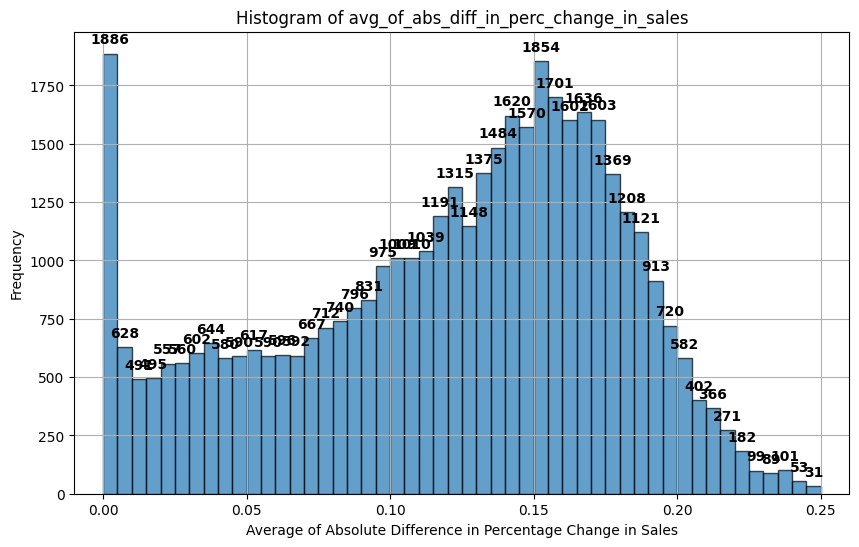

In [327]:
check = client.query(
    """ 
WITH step_one AS (
    SELECT 
        campaign_id, store_id, MIN(similarity_ranking) AS closest_match, MAX(similarity_ranking) AS furthest_match 
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians
    GROUP BY 1,2 
),
closest AS (
    SELECT 
        res.*, cm.closest_match, fm.furthest_match
    FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians res
    LEFT JOIN step_one cm 
        ON cm.campaign_id = res.campaign_id 
        AND cm.store_id = res.store_id 
        AND cm.closest_match = res.similarity_ranking
    LEFT JOIN step_one fm 
        ON fm.campaign_id = res.campaign_id 
        AND fm.store_id = res.store_id
        AND fm.furthest_match = res.similarity_ranking 
    WHERE fm.furthest_match IS NOT NULL OR cm.closest_match IS NOT NULL
)
SELECT 
    *
FROM closest 
WHERE closest_match IS NOT NULL
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

# Set the range for the bins
min_value = 0
max_value = 0.25
bins = 50  # Increase the number of bins for more granularity

# Plot the histogram
plt.figure(figsize=(10, 6))
counts, bin_edges, patches = plt.hist(check_df['avg_of_abs_diff_in_perc_change_in_sales'], bins=bins, range=(min_value, max_value), edgecolor='black', alpha=0.7)
plt.title('Histogram of avg_of_abs_diff_in_perc_change_in_sales')
plt.xlabel('Average of Absolute Difference in Percentage Change in Sales')
plt.ylabel('Frequency')
plt.grid(True)

# Set the x-axis limits slightly beyond the data range for better visualization
plt.xlim(min_value - 0.01, max_value + 0.01)

# Annotate the bars with the frequency count
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.annotate(f'{int(count)}', xy=(patch.get_x() + patch.get_width() / 2, height),
                 xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontweight='bold')

plt.show()

In [ ]:
check = client.query(
    """ 
SELECT 
    Category, 
    COUNT(DISTINCT CASE WHEN instore_only = 1 THEN campaign_id ELSE NULL END) AS n_campaigns_instore_only,
    COUNT(DISTINCT CASE WHEN instore_only = 1 AND average_discount_depth <= .05 THEN campaign_id ELSE NULL END) AS n_campaigns_instore_only_no_discount,
    COUNT(DISTINCT campaign_id) AS n_campaigns,
    COUNT(DISTINCT CASE WHEN average_discount_depth <= .05 THEN campaign_id ELSE NULL END) AS n_campaigns_no_discount
FROM gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_test_control_schema_three, 
UNNEST(SPLIT(categories, ", ")) AS Category
GROUP BY 1 
ORDER BY 3 DESC
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [283]:
check = client.query(
    """ 
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards AS 
with step_one AS (
   SELECT 
        booking_number, 
        campaign_start_date, 
        campaign_end_date, 
        store_id, 
        quoteline_sku, 
        ARRAY_AGG(media_type) AS media_types
   FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`,
   UNNEST(SPLIT(store_list, ",")) AS store_id 
   WHERE store_list IS NOT NULL 
   AND business_unit = 'Supermarket' 
   AND (LOWER(media_type) LIKE '%digital screen%' OR LOWER(media_type) LIKE '%hba screens%')
   AND store_list IS NOT NULL
   AND quoteline_sku IS NOT NULL
   AND campaign_start_date >= DATE("2023-01-01")
   GROUP BY ALL
), 
step_two AS (
    SELECT 
        booking_number, 
        campaign_start_date, 
        campaign_end_date, 
        store_id, 
        ARRAY_AGG(DISTINCT TRIM(sku) IGNORE NULLS ORDER BY TRIM(sku)) quoteline_skus 
    FROM step_one,
    UNNEST(SPLIT(quoteline_sku, ",")) AS sku
    GROUP BY 1,2,3,4
    ORDER BY 1,4
)
SELECT 
    step_two.booking_number, 
    step_two.campaign_start_date,
    step_two.campaign_end_date, 
    ARRAY_TO_STRING(quoteline_skus, ",") AS quoteline_skus_string, 
    ARRAY_TO_STRING(step_one.media_types, ",") AS media_types_string, 
    ARRAY_AGG(DISTINCT TRIM(step_two.store_id) IGNORE NULLS ORDER BY TRIM(step_two.store_id)) AS store_ids
FROM step_two 
LEFT JOIN step_one 
    ON step_two.booking_number = step_one.booking_number 
    AND step_two.campaign_start_date = step_one.campaign_start_date
    AND step_two.store_id = step_one.store_id
GROUP BY 1,2,3,4,5
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [ ]:
check = client.query(
    """ 
SELECT sales.* 
FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales sales
INNER JOIN `gcp-wow-ent-im-tbl-prod.adp_dm_masterdata_view.dim_site_v` dim_site 
    ON CAST(sales.Site AS STRING) = dim_site.Site
WHERE dim_site.SalesOrganisation = "1005"
ORDER BY total_baskets_campaign_period DESC 
LIMIT 3
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [26]:
check = client.query(
    """ 
    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.digital_screens_similarity_match_using_pre_vs_post_historical_uplift_method AS 
    with step_one AS (
        SELECT 
            sales.campaign_id, 
            sales.campaign_start_date, 
            sales.campaign_end_date,
            sales.n_days_campaign_period,
            sales.Site AS test_site, 
            comparison_sales.Site AS control_site, 
            sales.total_sales_campaign_period AS test_site_sales,
            comparison_sales.total_sales_campaign_period AS control_site_sales,
            sales.total_baskets_campaign_period AS test_site_baskets_with_promo_item,
            comparison_sales.total_baskets_campaign_period AS control_site_baskets_with_promo_item
        FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales sales
        INNER JOIN `gcp-wow-ent-im-tbl-prod.adp_dm_masterdata_view.dim_site_v` dim_site 
            ON CAST(sales.Site AS STRING) = dim_site.Site
        LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales comparison_sales
            ON sales.campaign_id = comparison_sales.campaign_id 
            AND sales.Site <> comparison_sales.Site 
            AND sales.test_or_control <> comparison_sales.test_or_control
        WHERE dim_site.SalesOrganisation = "1005"
        AND sales.test_or_control = "Test" 
        AND comparison_sales.test_or_control = "Control" 
    ),
    step_two AS (
        SELECT 
            step_one.*,
            sim.similarity_ranking,
            sim.n_comparison_campaign_ids,
            sim.campaign_start_date AS comparison_campaign_start_date,
            MAX(sim.campaign_start_date) OVER(PARTITION BY step_one.campaign_id ORDER BY sim.campaign_start_date) AS max_comparison_campaign_start_date
        FROM step_one 
        LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians sim 
            ON CAST(sim.store_id AS STRING) = CAST(step_one.test_site AS STRING)
            AND CAST(sim.comparison_store_id AS STRING) = CAST(step_one.control_site AS STRING)
        WHERE sim.campaign_start_date < step_one.campaign_start_date
        GROUP BY ALL 
    ),
    step_three AS (
        SELECT 
            campaign_id, 
            campaign_start_date, 
            test_site, 
            MIN(similarity_ranking) AS min_sim_rank
        FROM step_two
        WHERE comparison_campaign_start_date = max_comparison_campaign_start_date
        GROUP BY ALL 
    ),
    step_four AS (
        SELECT 
            step_two.*
        FROM step_two 
        INNER JOIN step_three 
            ON step_two.campaign_id = step_three.campaign_id 
            AND step_two.campaign_start_date = step_three.campaign_start_date 
            AND step_two.test_site = step_three.test_site 
            AND step_two.similarity_ranking = step_three.min_sim_rank 
    ), step_five AS (
        SELECT 
            step_four.*,
            MAX(step_four.n_comparison_campaign_ids) OVER(PARTITION BY campaign_id, test_site, similarity_ranking) AS max_n_comparison_campaign_ids  
        FROM step_four 
    ), step_six AS (
        SELECT * FROM step_five WHERE n_comparison_campaign_ids = max_n_comparison_campaign_ids 
    )
    SELECT DISTINCT * FROM step_six ORDER BY campaign_id, test_site 
    
    
    
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [ ]:

check = client.query(
"""

    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.unique_skus AS (
        SELECT DISTINCT 
            booking_number, 
            sku 
        FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards, 
        UNNEST(SPLIT(quoteline_skus_string, ",")) AS sku 
        WHERE booking_number = current_campaign_global_var --"WOW20007136"
        AND sku IS NOT NULL
    );

    CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.test_stores AS (
        SELECT DISTINCT 
            booking_number, 
            test_store 
        FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards, 
        UNNEST(store_ids) AS test_store 
        WHERE booking_number = current_campaign_global_var
        AND test_store IS NOT NULL
    );



            
        DELETE FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_during_period WHERE campaign_id = current_campaign_global_var;
        INSERT INTO gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_during_period 
            SELECT 
                trading.booking_number AS campaign_id,
                trading.campaign_start_date,
                trading.campaign_end_date,
                ass_campaign_period.Site, 
                CASE WHEN test_stores.test_store IS NOT NULL THEN "Test" ELSE "Control" END AS test_or_control, 
                ARRAY_AGG(DISTINCT Article IGNORE NULLS ORDER BY Article) AS campaign_skus,
                
                -- Pre Period Sales (total and daily avg)
                COUNT(DISTINCT ass_campaign_period.TXNStartDate) AS n_days_campaign_period,
                SUM(ass_campaign_period.TotalAmountIncldTax) AS total_sales_campaign_period,
                COUNT(DISTINCT ass_campaign_period.BasketKey) AS total_baskets_campaign_period

            FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass_campaign_period
            LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards trading
                ON ass_campaign_period.TXNStartDate >= trading.campaign_start_date 
                AND ass_campaign_period.TXNStartDate <= trading.campaign_end_date 

            INNER JOIN gcp-wow-cart-data-dev-d4d7.davide.unique_skus skus 
                ON skus.sku = ass_campaign_period.Article 

            LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.test_stores test_stores 
                ON CAST(test_stores.test_store AS INT64) = CAST(ass_campaign_period.Site AS INT64)

            WHERE trading.booking_number = current_campaign_global_var
            AND LOWER(ass_campaign_period.SalesChannelDescription) <> "online"
            AND ass_campaign_period.TXNStartDate >= trading.campaign_start_date 
            AND ass_campaign_period.TXNStartDate <= trading.campaign_end_Date
            AND ass_campaign_period.SalesOrg = 1005
            GROUP BY ALL
        
    ;


    DELETE FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period WHERE campaign_id = current_campaign_global_var;
    INSERT INTO gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period
        SELECT 
            during_period.* EXCEPT(campaign_skus), 
            SUM(ass_pre_period.TotalAmountIncldTax) AS total_sales_pre_period,
            COUNT(DISTINCT ass_pre_period.BasketKey) AS total_baskets_pre_period
        FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_during_period during_period 
        LEFT JOIN `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass_pre_period
            ON ass_pre_period.TXNStartDate >= (during_period.campaign_start_date - during_period.n_days_campaign_period) AND ass_pre_period.TXNStartDate < during_period.campaign_start_date 
            AND CAST(during_period.Site AS INT64) = CAST(ass_pre_period.Site AS INT64)

        INNER JOIN gcp-wow-cart-data-dev-d4d7.davide.unique_skus skus 
            ON skus.sku = ass_pre_period.Article 

        WHERE LOWER(ass_pre_period.SalesChannelDescription) <> "online"
        AND ass_pre_period.SalesOrg = 1005
        AND during_period.campaign_id = current_campaign_global_var
        AND ass_pre_period.TXNStartDate >= (during_period.campaign_start_date - during_period.n_days_campaign_period) AND ass_pre_period.TXNStartDate < during_period.campaign_start_date 
        GROUP BY ALL
    ;
    
    
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:

check = client.query(
"""
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.instore_digital_screens_comparisons AS 
    with n_days AS (
        SELECT 
            campaign_id, 
            MAX(n_days_campaign_period) AS max_days_campaign_period 
        FROM  gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period 
        GROUP BY 1
    ),
    step_two AS (

        SELECT res.*, 
            total_sales_campaign_period / (total_sales_pre_period) - 1 AS perc_sales_uplift
        FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period res
        LEFT JOIN n_days
            ON res.campaign_id = n_days.campaign_id 
            AND res.n_days_campaign_period = n_days.max_days_campaign_period 
        WHERE max_days_campaign_period IS NOT NULL
    ),

    step_three AS (
        SELECT
            test.campaign_id, 
            test.campaign_start_date,
            test.campaign_end_date,
            test.Site AS test_store, 
            control.Site AS control_store,
            test.perc_sales_uplift AS test_store_uplift, 
            control.perc_sales_uplift AS control_store_uplift, 
            test.total_sales_pre_period AS test_store_pre_sales,
            control.total_sales_pre_period AS control_store_pre_sales,
            test.total_sales_campaign_period AS test_store_campaign_sales, 
            control.total_sales_campaign_period AS control_store_campaign_sales
        FROM step_two test
        LEFT JOIN step_two control 
            ON test.campaign_id = control.campaign_id 
            AND test.Site <> control.Site 
        WHERE test.test_or_control = "Test" 
        AND control.test_or_control = "Control" 
    ), 
    step_four AS (
        SELECT 
            step_three.*,
            sim.similarity_ranking,
            sim.n_comparison_campaign_ids,
            sim.campaign_start_date AS comparison_campaign_start_date,
            MAX(sim.campaign_start_date) OVER(PARTITION BY step_three.campaign_id ORDER BY sim.campaign_start_date) AS max_comparison_campaign_start_date
        FROM step_three 
        LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians sim 
            ON CAST(sim.store_id AS STRING) = CAST(step_three.test_store AS STRING)
            AND CAST(sim.comparison_store_id AS STRING) = CAST(step_three.control_store AS STRING)
        WHERE sim.campaign_start_date < step_three.campaign_start_date
        GROUP BY ALL 
    ), 

        step_five AS (
            SELECT 
                campaign_id, 
                campaign_start_date, 
                test_store, 
                MIN(similarity_ranking) AS min_sim_rank
            FROM step_four
            WHERE comparison_campaign_start_date = max_comparison_campaign_start_date
            GROUP BY ALL 
        ),
        step_six AS (
            SELECT 
                step_four.*
            FROM step_four 
            INNER JOIN step_five 
                ON step_four.campaign_id = step_five.campaign_id 
                AND step_four.campaign_start_date = step_five.campaign_start_date 
                AND step_four.test_store = step_five.test_store
                AND step_four.similarity_ranking = step_five.min_sim_rank 
        ), 
        
        step_seven AS (
            SELECT 
                step_six.*,
                MAX(step_six.n_comparison_campaign_ids) OVER(PARTITION BY campaign_id, test_store, similarity_ranking) AS max_n_comparison_campaign_ids  
            FROM step_six 
        ), 
        
        step_eight AS (
            SELECT * FROM step_seven WHERE n_comparison_campaign_ids = max_n_comparison_campaign_ids 
        ),
        step_nine AS (
            SELECT DISTINCT * FROM step_eight ORDER BY campaign_id, test_store
        )
            SELECT 
                campaign_id, 
                campaign_start_date,
                campaign_end_date, 
                test_store,
                control_store, 
                test_store_uplift,
                control_store_uplift, 
                test_store_uplift - control_store_uplift AS uplift_effect,
                test_store_pre_sales,
                test_store_campaign_sales,
                control_store_pre_sales,
                control_store_campaign_sales, 
                similarity_ranking, 
                n_comparison_campaign_ids
            FROM step_nine 
;
    
        

    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [51]:

check = client.query(
"""
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.instore_digital_screens_comparisons_step_two AS
    with 
    
    n_days AS (
        SELECT 
            campaign_id, 
            MAX(n_days_campaign_period) AS max_days_campaign_period 
        FROM  gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period 
        GROUP BY 1
    ),

    step_two AS (
        SELECT res.*, 
            total_sales_campaign_period / (total_sales_pre_period) - 1 AS perc_sales_uplift
        FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period res
        LEFT JOIN n_days
            ON res.campaign_id = n_days.campaign_id 
            AND res.n_days_campaign_period = n_days.max_days_campaign_period 
        WHERE max_days_campaign_period IS NOT NULL
    ),

    step_three AS (
        SELECT
            test.campaign_id, 
            test.campaign_start_date,
            test.campaign_end_date,
            test.Site AS test_store, 
            control.Site AS control_store,
            test.perc_sales_uplift AS test_store_uplift, 
            control.perc_sales_uplift AS control_store_uplift, 
            test.total_sales_pre_period AS test_store_pre_sales,
            control.total_sales_pre_period AS control_store_pre_sales,
            test.total_sales_campaign_period AS test_store_campaign_sales, 
            control.total_sales_campaign_period AS control_store_campaign_sales
        FROM step_two test
        LEFT JOIN step_two control 
            ON test.campaign_id = control.campaign_id 
            AND test.Site <> control.Site 
        WHERE test.test_or_control = "Test" 
        AND control.test_or_control = "Control" 
    ), 

    step_four AS (
        SELECT 
            step_three.*,
            sim.similarity_ranking,
            sim.n_comparison_campaign_ids,
            sim.campaign_start_date AS comparison_campaign_start_date,
            MAX(sim.campaign_start_date) OVER(PARTITION BY step_three.campaign_id ORDER BY sim.campaign_start_date) AS max_comparison_campaign_start_date
        FROM step_three 
        LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.cartology_incrementality_retro_analysis_store_comparison_of_prior_campaign_impact_medians sim 
            ON CAST(sim.store_id AS STRING) = CAST(step_three.test_store AS STRING)
            AND CAST(sim.comparison_store_id AS STRING) = CAST(step_three.control_store AS STRING)
        WHERE sim.campaign_start_date < step_three.campaign_start_date
        GROUP BY ALL 
    ), 

    step_five AS (
        SELECT 
            campaign_id, 
            campaign_start_date, 
            test_store, 
            MIN(similarity_ranking) AS min_sim_rank
        FROM step_four
        WHERE comparison_campaign_start_date = max_comparison_campaign_start_date
        GROUP BY ALL 
    ),

    step_six AS (
        SELECT 
            step_four.*
        FROM step_four 
        INNER JOIN step_five 
            ON step_four.campaign_id = step_five.campaign_id 
            AND step_four.campaign_start_date = step_five.campaign_start_date 
            AND step_four.test_store = step_five.test_store
            AND step_four.similarity_ranking = step_five.min_sim_rank 
    ), 
    
    step_seven AS (
        SELECT 
            step_six.*,
            MAX(step_six.n_comparison_campaign_ids) OVER(PARTITION BY campaign_id, test_store, similarity_ranking) AS max_n_comparison_campaign_ids  
        FROM step_six 
    ), 
    
    step_eight AS (
        SELECT * FROM step_seven WHERE n_comparison_campaign_ids = max_n_comparison_campaign_ids 
    ),

    step_nine AS (
        SELECT DISTINCT * FROM step_eight ORDER BY campaign_id, test_store
    ),

    step_ten AS (
        SELECT 
            campaign_id, 
            campaign_start_date,
            campaign_end_date, 
            test_store,
            control_store, 
            test_store_uplift,
            control_store_uplift, 
            test_store_uplift - control_store_uplift AS uplift_effect,
            test_store_pre_sales,
            test_store_campaign_sales,
            control_store_pre_sales,
            control_store_campaign_sales, 
            similarity_ranking, 
            n_comparison_campaign_ids
        FROM step_nine 
    )
    SELECT 
        campaign_id, 
        AVG(uplift_effect) AS average_uplift_effect 
    FROM step_ten 
    GROUP BY 1
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

""


In [70]:

check = client.query(
"""
SELECT * 
FROM gcp-wow-cart-data-dev-d4d7.davide.instore_digital_screens_comparisons_step_two 
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,average_uplift_effect
0,WOW20006800,-1.115749600
1,WOW20006364,-0.338693048
2,WOW20007136,0.015705321
3,WOW20005828,-0.029610692
4,WOW20005856,0.036020192
5,WOW20006679,0.010937376
6,WOW20009532,0.092721681
7,WOW20006345,0.790718636
8,WOW20006796,-0.120669131


In [ ]:

check = client.query(
"""
SELECT * 
FROM `gcp-wow-cart-data-dev-d4d7.davide.instore_screens_run_logs` 
WHERE query_step = "6"
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

In [105]:

check = client.query(
"""
    SELECT
        res.*, 
        n_days.n_days_campaign_period, 
        n_days.n_days_pre_period + 1, 

        baskets_test.total_baskets_pre_period AS test_store_baskets_pre_period, 
        baskets_test.total_baskets_campaign_period AS test_store_baskets_campaign_period,
        baskets_control.total_baskets_pre_period AS control_store_baskets_pre_period, 
        baskets_control.total_baskets_campaign_period AS control_store_baskets_campaign_period,

        baskets_test.total_baskets_pre_period / n_days.n_days_pre_period AS test_store_transactions_per_day_pre_period,
        baskets_test.total_baskets_campaign_period / n_days.n_days_pre_period AS test_store_transactions_per_day_campaign_period,

        baskets_control.total_baskets_pre_period / n_days.n_days_pre_period AS control_store_transactions_per_day_pre_period,
        baskets_control.total_baskets_campaign_period / n_days.n_days_pre_period AS control_store_transactions_per_day_campaign_period


        
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_digital_screens_comparisons_store_level res
    LEFT JOIN (SELECT campaign_id, MAX(n_days_campaign_period) AS n_days_campaign_period, MAX(n_days_pre_period) AS n_days_pre_period FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period GROUP BY 1) n_days
        ON res.campaign_id = n_days.campaign_id
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period AS baskets_test 
        ON baskets_test.campaign_id = res.campaign_id 
        AND baskets_test.Site = res.test_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period AS baskets_control 
        ON baskets_control.campaign_id = res.campaign_id 
        AND baskets_control.Site = res.control_store 

    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,campaign_start_date,campaign_end_date,test_store,control_store,test_store_uplift,control_store_uplift,uplift_effect,test_store_pre_sales,test_store_campaign_sales,control_store_pre_sales,control_store_campaign_sales,similarity_ranking,n_comparison_campaign_ids,n_days_campaign_period,f0_,test_store_baskets_pre_period,test_store_baskets_campaign_period,control_store_baskets_pre_period,control_store_baskets_campaign_period,test_store_transactions_per_day_pre_period,test_store_transactions_per_day_campaign_period,control_store_transactions_per_day_pre_period,control_store_transactions_per_day_campaign_period
0,WOW20006706,2024-01-03,2024-02-13,3364,2048,0.128347943,1.091270561,-0.962922618,985.680000000,1112.190000000,1433.540000000,2997.920000000,1,9,42,42,128,227,178,457,3.121951,5.536585,4.341463,11.146341
1,WOW20006706,2024-01-03,2024-02-13,2634,2048,0.344999437,1.091270561,-0.746271124,1153.770000000,1551.820000000,1433.540000000,2997.920000000,1,20,42,42,142,282,178,457,3.463415,6.878049,4.341463,11.146341
2,WOW20006706,2024-01-03,2024-02-13,2759,3336,0.711201205,0.015181126,0.696020079,1181.480000000,2021.750000000,992.680000000,1007.750000000,1,27,42,42,165,353,120,196,4.024390,8.609756,2.926829,4.780488
3,WOW20006706,2024-01-03,2024-02-13,3145,3336,-0.027988974,0.015181126,-0.043170100,1200.830000000,1167.220000000,992.680000000,1007.750000000,1,32,42,42,175,216,120,196,4.268293,5.268293,2.926829,4.780488
4,WOW20006706,2024-01-03,2024-02-13,1315,3337,0.399013750,0.633524707,-0.234510957,622.560000000,870.970000000,1320.280000000,2156.710000000,1,17,42,42,82,151,184,373,2.000000,3.682927,4.487805,9.097561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,WOW20007431,2024-01-03,2024-02-06,2576,2559,0.327490954,0.468568211,-0.141077257,3147.690000000,4178.530000000,2255.360000000,3312.150000000,1,12,35,35,433,686,318,540,12.735294,20.176471,9.352941,15.882353
3192,WOW20007461,2024-01-03,2024-02-06,2077,2559,0.716998092,0.478445614,0.238552478,1724.370000000,2960.740000000,1878.040000000,2776.580000000,1,21,35,35,104,195,119,170,3.058824,5.735294,3.500000,5.000000
3193,WOW20008109,2024-01-03,2024-02-06,2576,2559,0.220396201,0.521369018,-0.300972817,1504.790000000,1836.440000000,742.430000000,1129.510000000,1,12,35,35,185,255,93,170,5.441176,7.500000,2.735294,5.000000
3194,WOW20007461,2024-01-03,2024-02-06,5634,3327,0.456054779,0.107611864,0.348442915,4584.230000000,6674.890000000,6573.160000000,7280.510000000,1,22,35,35,239,397,309,426,7.029412,11.676471,9.088235,12.529412


In [107]:

check = client.query(
"""

with step_one AS (
    SELECT 

        res.*, 
        n_days.n_days_campaign_period, 
        n_days.n_days_pre_period, 

        baskets_test.total_baskets_pre_period AS test_store_baskets_pre_period, 
        baskets_test.total_baskets_campaign_period AS test_store_baskets_campaign_period,
        baskets_control.total_baskets_pre_period AS control_store_baskets_pre_period, 
        baskets_control.total_baskets_campaign_period AS control_store_baskets_campaign_period,

        baskets_test.total_baskets_pre_period / n_days.n_days_pre_period AS test_store_transactions_per_day_pre_period,
        baskets_test.total_baskets_campaign_period / n_days.n_days_pre_period AS test_store_transactions_per_day_campaign_period,

        baskets_control.total_baskets_pre_period / n_days.n_days_pre_period AS control_store_transactions_per_day_pre_period,
        baskets_control.total_baskets_campaign_period / n_days.n_days_pre_period AS control_store_transactions_per_day_campaign_period


        
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_digital_screens_comparisons_store_level res
    LEFT JOIN (SELECT campaign_id, MAX(n_days_campaign_period) AS n_days_campaign_period, MAX(n_days_pre_period) AS n_days_pre_period FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period GROUP BY 1) n_days
        ON res.campaign_id = n_days.campaign_id
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period AS baskets_test 
        ON baskets_test.campaign_id = res.campaign_id 
        AND baskets_test.Site = res.test_store 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period AS baskets_control 
        ON baskets_control.campaign_id = res.campaign_id 
        AND baskets_control.Site = res.control_store 
),

step_two AS (

    SELECT DISTINCT *
    FROM step_one 
    WHERE 
        test_store_transactions_per_day_pre_period >= 10
    AND 
        test_store_transactions_per_day_campaign_period >= 10
    AND 
        control_store_transactions_per_day_pre_period >= 10
    AND 
        control_store_transactions_per_day_campaign_period >= 10
),
step_three AS (

    SELECT 
        campaign_id, 
        n_days_pre_period + 1 AS n_days_pre_period,
        n_days_campaign_period,
        COUNT(DISTINCT test_store) AS n_test_stores,
        COUNT(DISTINCT control_store) AS n_control_stores,
        AVG(uplift_effect) AS avg_uplift_effect
    FROM step_two 
    GROUP BY 1,2,3
)
SELECT *, 
    CASE WHEN n_control_stores >= 100 AND avg_uplift_effect >= 0.01 THEN "1" ELSE "0" END AS attributable_to_campaign
FROM step_three
    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,campaign_id,n_days_pre_period,n_days_campaign_period,n_test_stores,n_control_stores,avg_uplift_effect,attributable_to_campaign
0,WOW20005828,7,7,133,104,0.007695955,0
1,WOW20006679,28,28,7,6,0.016575321,0
2,WOW20006501,35,35,102,79,0.005100382,0
3,WOW20007085,35,35,450,181,-0.014447303,0
4,WOW20007136,35,35,230,162,0.015656357,1
5,WOW20007431,35,35,86,59,0.002578553,0
6,WOW20007461,35,35,12,13,-0.014285578,0
7,WOW20008109,35,35,1,1,-0.106751796,0
8,WOW20008320,8,7,1,1,0.671480815,0
9,WOW20007430,35,35,190,153,0.011682263,1


In [61]:

check = client.query(
"""
with step_one AS (
SELECT 
    booking_number, 
    ARRAY_AGG(DISTINCT media_types ORDER BY media_types) AS media_types
FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards,
UNNEST(SPLIT(media_types_string, ",")) AS media_types
GROUP BY 1
) 
SELECT DISTINCT 
    ARRAY_TO_STRING(media_types, ", ") AS media_types 
    FROM step_one

    """
).result()
check_df = check.to_dataframe()
chime.success()
check_df

,media_types
0,Digital Screens Supers
1,Metro Digital Screens
2,"Digital Screens Supers, Metro Digital Screens"
3,"Digital Screens Supers, Digital Screens Supers - B&R"
4,Digital Screens Supers - B&R
5,HBA Screens


/var/folders/pz/tmsv9qjs4g36095qthg4dsw80000gn/T/ipykernel_66795/868755853.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['perc_sales_uplift'], label=group, color=colors[group], shade=True)
/var/folders/pz/tmsv9qjs4g36095qthg4dsw80000gn/T/ipykernel_66795/868755853.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['perc_sales_uplift'], label=group, color=colors[group], shade=True)


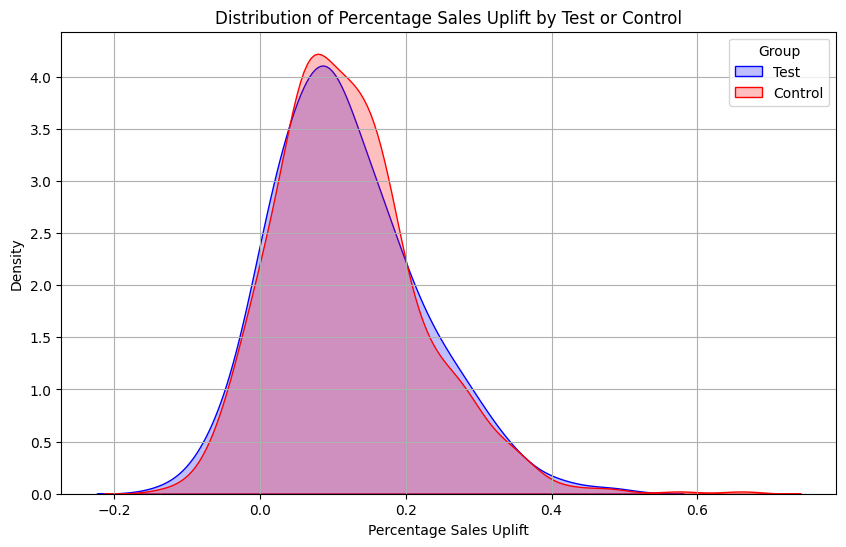

In [43]:
# Define colors for the test and control groups
colors = {'Test': 'blue', 'Control': 'red'}

# Plotting
plt.figure(figsize=(10, 6))
for group in check_df['test_or_control'].unique():
    subset = check_df[check_df['test_or_control'] == group]
    sns.kdeplot(subset['perc_sales_uplift'], label=group, color=colors[group], shade=True)

plt.title('Distribution of Percentage Sales Uplift by Test or Control')
plt.xlabel('Percentage Sales Uplift')
plt.ylabel('Density')
plt.legend(title='Group')
plt.grid(True)
plt.show()